In [6]:
import pandas as pd
import zipfile
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import os
import gc

def process_mat_files_optimized(folder_path, output_dir="/content/processed_data"):
    """Przetwarza pliki .mat jeden po drugim, oszczędzając RAM"""

    # Stwórz folder na wyniki
    os.makedirs(output_dir, exist_ok=True)

    processed_files = []
    total_zips = len(list(Path(folder_path).glob("*.zip")))

    print(f"🎯 Znaleziono {total_zips} plików ZIP do przetworzenia")
    print("🔄 Przetwarzanie po jednym pliku (oszczędzanie RAM)...\n")

    zip_counter = 0

    for zip_path in Path(folder_path).glob("*.zip"):
        zip_counter += 1
        print(f"📦 [{zip_counter}/{total_zips}] Przetwarzam: {zip_path.name}")

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                for file_info in zip_ref.infolist():
                    if file_info.filename.endswith('.mat'):
                        print(f"  📄 Czytam: {file_info.filename}")

                        try:
                            # Wczytaj pojedynczy plik .mat
                            mat_data = zip_ref.read(file_info.filename)
                            temp_path = f"/tmp/{file_info.filename}"

                            with open(temp_path, 'wb') as temp_file:
                                temp_file.write(mat_data)

                            # Wczytaj .mat
                            mat_dict = loadmat(temp_path)
                            os.remove(temp_path)

                            # Konwertuj od razu do DataFrame
                            df = convert_single_mat_to_df(mat_dict, zip_path.name, file_info.filename)

                            # Zapisz jako pojedynczy plik parquet
                            output_filename = f"{zip_path.stem}_{file_info.filename.replace('.mat', '')}.parquet"
                            output_path = os.path.join(output_dir, output_filename)

                            df.to_parquet(output_path, index=False)
                            processed_files.append(output_path)

                            print(f"    ✅ Zapisano: {output_filename} ({df.shape})")

                            # WAŻNE: Wyczyść pamięć po każdym pliku
                            del mat_dict, df
                            gc.collect()

                        except Exception as e:
                            print(f"    ❌ Błąd: {e}")

        except Exception as e:
            print(f"❌ Błąd z zipem {zip_path.name}: {e}")

        # Sprawdź pamięć co kilka plików
        if zip_counter % 5 == 0:
            check_memory_status()

    print(f"\n✅ Przetworzono {len(processed_files)} plików!")
    return processed_files

def convert_single_mat_to_df(mat_dict, zip_name, file_name):
    """Konwertuje pojedynczy plik .mat do DataFrame z optymalizacją typów"""

    # Wyciągnij metadata
    subject = mat_dict['subject'][0,0] if mat_dict['subject'].shape == (1,1) else mat_dict['subject']
    exercise = mat_dict['exercise'][0,0] if mat_dict['exercise'].shape == (1,1) else mat_dict['exercise']

    # Stwórz DataFrame z optymalnymi typami danych (oszczędność pamięci)
    df = pd.DataFrame({
        'subject': np.uint8(subject),
        'exercise': np.uint8(exercise),
        'stimulus': mat_dict['stimulus'].flatten().astype(np.uint8),
        'restimulus': mat_dict['restimulus'].flatten().astype(np.uint8),
        'repetition': mat_dict['repetition'].flatten().astype(np.uint8),
        'rerepetition': mat_dict['rerepetition'].flatten().astype(np.uint8),
        'source_zip': zip_name,
        'source_file': file_name
    })

    # Dodaj kolumny EMG (zmień na float32 zamiast float64)
    emg_data = mat_dict['emg'].astype(np.float32)
    for i in range(emg_data.shape[1]):
        df[f'emg_{i+1}'] = emg_data[:, i]

    # Dodaj kolumny glove (zmień na float32)
    glove_data = mat_dict['glove'].astype(np.float32)
    for i in range(glove_data.shape[1]):
        df[f'glove_{i+1}'] = glove_data[:, i]

    # Dodaj indeks próbki
    df['sample_index'] = np.arange(len(df), dtype=np.uint32)

    return df

def check_memory_status():
    """Sprawdza status pamięci"""
    try:
        import psutil
        ram = psutil.virtual_memory()
        print(f"    💾 RAM: {ram.percent:.1f}% used ({ram.available / (1024**3):.1f} GB free)")

        if ram.percent > 85:
            print("    ⚠️ Wysoki poziom RAM - wymuszam garbage collection")
            gc.collect()

    except ImportError:
        print("    💾 (psutil niedostępne - nie można sprawdzić RAM)")

# Uruchom przetwarzanie
processed_files = process_mat_files_optimized("/content/processed_data")

🎯 Znaleziono 27 plików ZIP do przetworzenia
🔄 Przetwarzanie po jednym pliku (oszczędzanie RAM)...

📦 [1/27] Przetwarzam: s18.zip
  📄 Czytam: S18_A1_E1.mat
    ✅ Zapisano: s18_S18_A1_E1.parquet ((101323, 41))
  📄 Czytam: S18_A1_E2.mat
    ✅ Zapisano: s18_S18_A1_E2.parquet ((143460, 41))
  📄 Czytam: S18_A1_E3.mat
    ✅ Zapisano: s18_S18_A1_E3.parquet ((220750, 41))
📦 [2/27] Przetwarzam: s8.zip
  📄 Czytam: S8_A1_E1.mat
    ✅ Zapisano: s8_S8_A1_E1.parquet ((100854, 41))
  📄 Czytam: S8_A1_E2.mat
    ✅ Zapisano: s8_S8_A1_E2.parquet ((142773, 41))
  📄 Czytam: S8_A1_E3.mat
    ✅ Zapisano: s8_S8_A1_E3.parquet ((206103, 41))
📦 [3/27] Przetwarzam: s3.zip
  📄 Czytam: S3_A1_E1.mat
    ✅ Zapisano: s3_S3_A1_E1.parquet ((100720, 41))
  📄 Czytam: S3_A1_E2.mat
    ✅ Zapisano: s3_S3_A1_E2.parquet ((142682, 41))
  📄 Czytam: S3_A1_E3.mat
    ✅ Zapisano: s3_S3_A1_E3.parquet ((224375, 41))
📦 [4/27] Przetwarzam: s20.zip
  📄 Czytam: S20_A1_E1.mat
    ✅ Zapisano: s20_S20_A1_E1.parquet ((101565, 41))
  📄 Czytam:

In [7]:
def combine_processed_files(processed_dir="/content/processed_data", batch_size=10):
    """Łączy przetworzone pliki parquet w batches"""

    parquet_files = list(Path(processed_dir).glob("*.parquet"))
    print(f"📁 Znaleziono {len(parquet_files)} plików do połączenia")

    if not parquet_files:
        print("❌ Brak plików do połączenia!")
        return None

    # Przetwarzaj w batches
    all_batches = []

    for i in range(0, len(parquet_files), batch_size):
        batch_files = parquet_files[i:i+batch_size]
        print(f"🔗 Batch {i//batch_size + 1}: łączę {len(batch_files)} plików...")

        batch_dfs = []
        for file_path in batch_files:
            df = pd.read_parquet(file_path)
            batch_dfs.append(df)

        # Połącz batch
        batch_combined = pd.concat(batch_dfs, ignore_index=True)
        all_batches.append(batch_combined)

        # Wyczyść pamięć
        del batch_dfs
        gc.collect()

        check_memory_status()

    # Ostateczne połączenie wszystkich batches
    print("🔗 Końcowe łączenie wszystkich batches...")
    final_df = pd.concat(all_batches, ignore_index=True)

    # Zapisz wynik
    final_df.to_parquet("/content/final_emg_dataset.parquet", index=False)
    print(f"✅ Gotowe! Finalne dane: {final_df.shape}")
    print(f"💾 Zapisano jako: final_emg_dataset.parquet")

    return final_df

# Połącz przetworzone pliki
final_dataset = combine_processed_files()

# Sprawdź rezultat
if final_dataset is not None:
    print(f"\n📊 Finalne statystyki:")
    print(f"Shape: {final_dataset.shape}")
    print(f"Kolumny: {len(final_dataset.columns)}")
    print(f"Unikalne subjects: {final_dataset['subject'].nunique()}")
    print(f"Unikalne exercises: {final_dataset['exercise'].nunique()}")
    print(f"Pamięć: {final_dataset.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

📁 Znaleziono 81 plików do połączenia
🔗 Batch 1: łączę 10 plików...
    💾 RAM: 16.8% used (10.6 GB free)
🔗 Batch 2: łączę 10 plików...
    💾 RAM: 19.1% used (10.3 GB free)
🔗 Batch 3: łączę 10 plików...
    💾 RAM: 21.2% used (10.0 GB free)
🔗 Batch 4: łączę 10 plików...
    💾 RAM: 22.7% used (9.8 GB free)
🔗 Batch 5: łączę 10 plików...
    💾 RAM: 24.2% used (9.6 GB free)
🔗 Batch 6: łączę 10 plików...
    💾 RAM: 25.8% used (9.4 GB free)
🔗 Batch 7: łączę 10 plików...
    💾 RAM: 27.9% used (9.1 GB free)
🔗 Batch 8: łączę 10 plików...
    💾 RAM: 29.6% used (8.9 GB free)
🔗 Batch 9: łączę 1 plików...
    💾 RAM: 29.7% used (8.9 GB free)
🔗 Końcowe łączenie wszystkich batches...
✅ Gotowe! Finalne dane: (12553611, 41)
💾 Zapisano jako: final_emg_dataset.parquet

📊 Finalne statystyki:
Shape: (12553611, 41)
Kolumny: 41
Unikalne subjects: 27
Unikalne exercises: 3
Pamięć: 3252.0 MB


🚀 ROZPOCZYNAM PEŁNĄ ANALIZĘ EDA
✅ Wczytano dane z /content/final_emg_dataset.parquet
📊 Kształt danych: (12553611, 41)
📈 PODSTAWOWE INFORMACJE O DATASECIE
🔢 Liczba przykładów (wierszy): 12,553,611
🔢 Liczba kolumn: 41
💾 Rozmiar w pamięci: 3252.0 MB
📡 Liczba kanałów EMG: 10
🧤 Liczba sensorów rękawicy: 22

🏷️ Kolumny EMG: ['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'emg_10']
🏷️ Kolumny glove: ['glove_1', 'glove_2', 'glove_3', 'glove_4', 'glove_5']...

👥 ANALIZA UCZESTNIKÓW I ĆWICZEŃ
👤 Liczba uczestników: 27
🏋️ Liczba typów ćwiczeń: 3

👤 Lista uczestników: [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19), np.uint8(20), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(25), np.uint8(26), np.uint8(27)]
🏋️ Lista ćwiczeń: [np.uint8(1), np

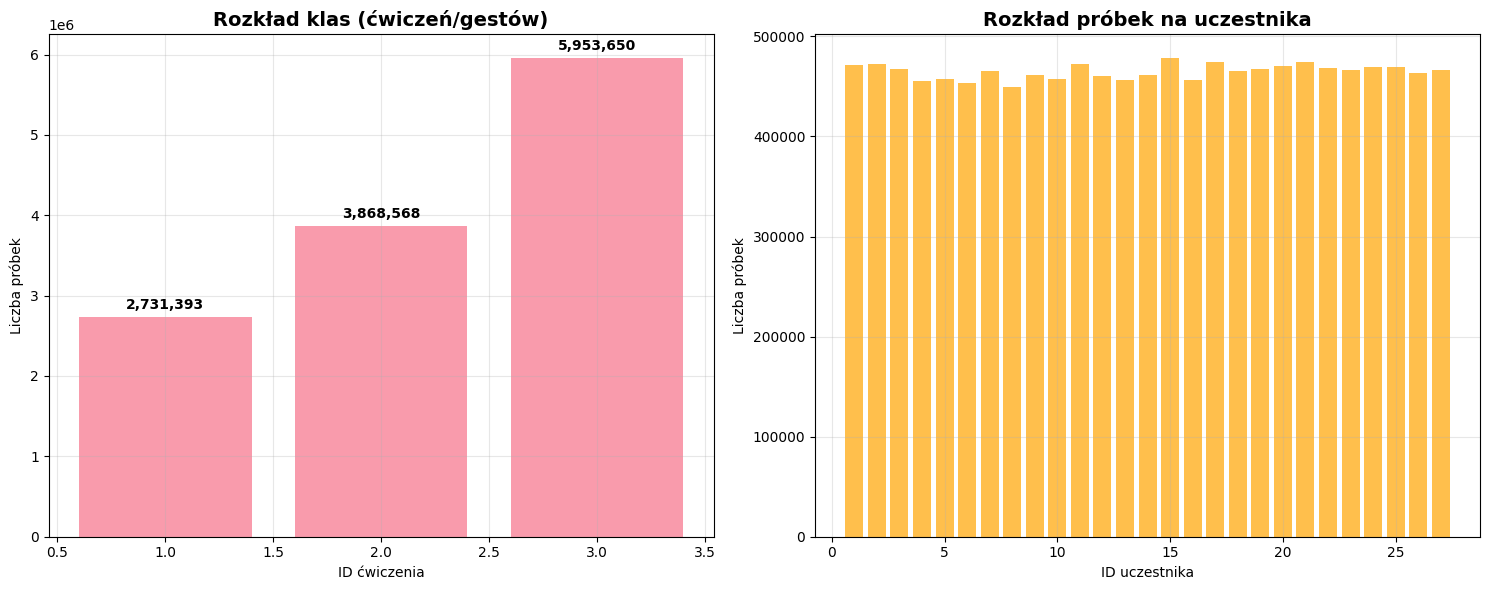


📏 ANALIZA DŁUGOŚCI SYGNAŁÓW
📊 Statystyki długości sygnałów:
   Średnia długość: 154983 próbek
   Mediana: 142999 próbek
   Min długość: 100686 próbek
   Max długość: 232710 próbek
   Odchylenie std: 49875 próbek


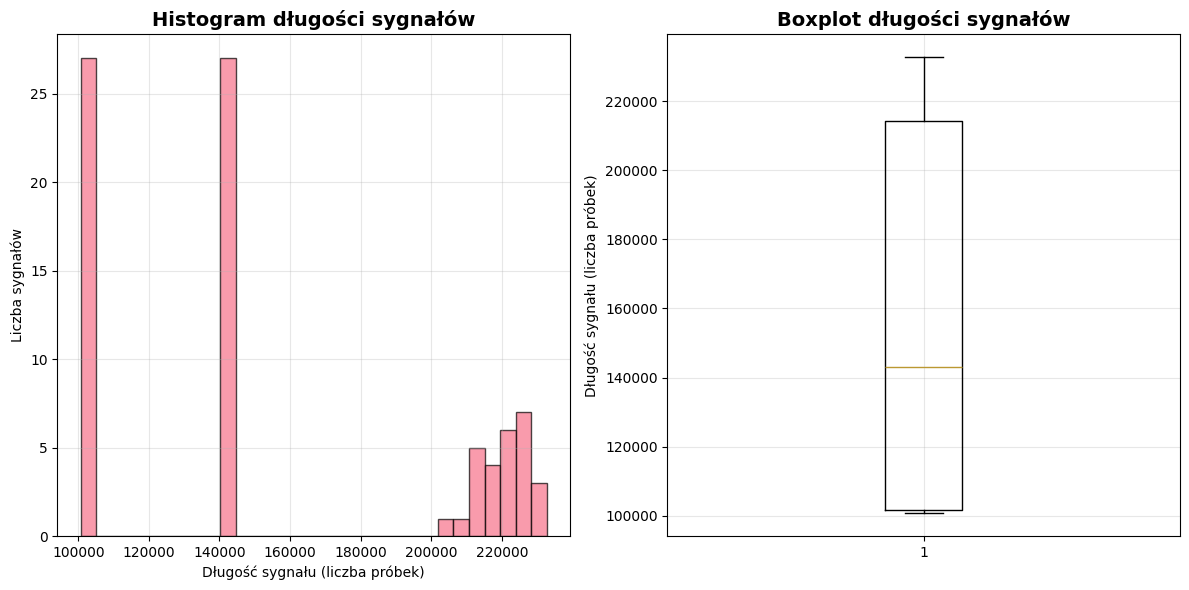


📡 ANALIZA KANAŁÓW EMG
📊 Statystyki opisowe kanałów EMG:
              emg_1         emg_2         emg_3         emg_4         emg_5  \
count  1.255361e+07  1.255361e+07  1.255361e+07  1.255361e+07  1.255361e+07   
mean   2.372000e-01  1.391000e-01  1.257000e-01  6.570000e-02  2.370000e-02   
std    4.139000e-01  2.916000e-01  3.301000e-01  2.034000e-01  8.090000e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.400000e-03  2.400000e-03  2.400000e-03  2.400000e-03  2.400000e-03   
50%    5.370000e-02  4.900000e-03  2.400000e-03  2.400000e-03  2.400000e-03   
75%    2.832000e-01  1.440000e-01  8.790000e-02  2.440000e-02  7.300000e-03   
max    4.668000e+00  4.668000e+00  4.663100e+00  4.665500e+00  4.663100e+00   

              emg_6         emg_7         emg_8         emg_9        emg_10  
count  1.255361e+07  1.255361e+07  1.255361e+07  1.255361e+07  1.255361e+07  
mean   6.110000e-02  3.182000e-01  3.360000e-01  1.230000e-01  2.301000e-01

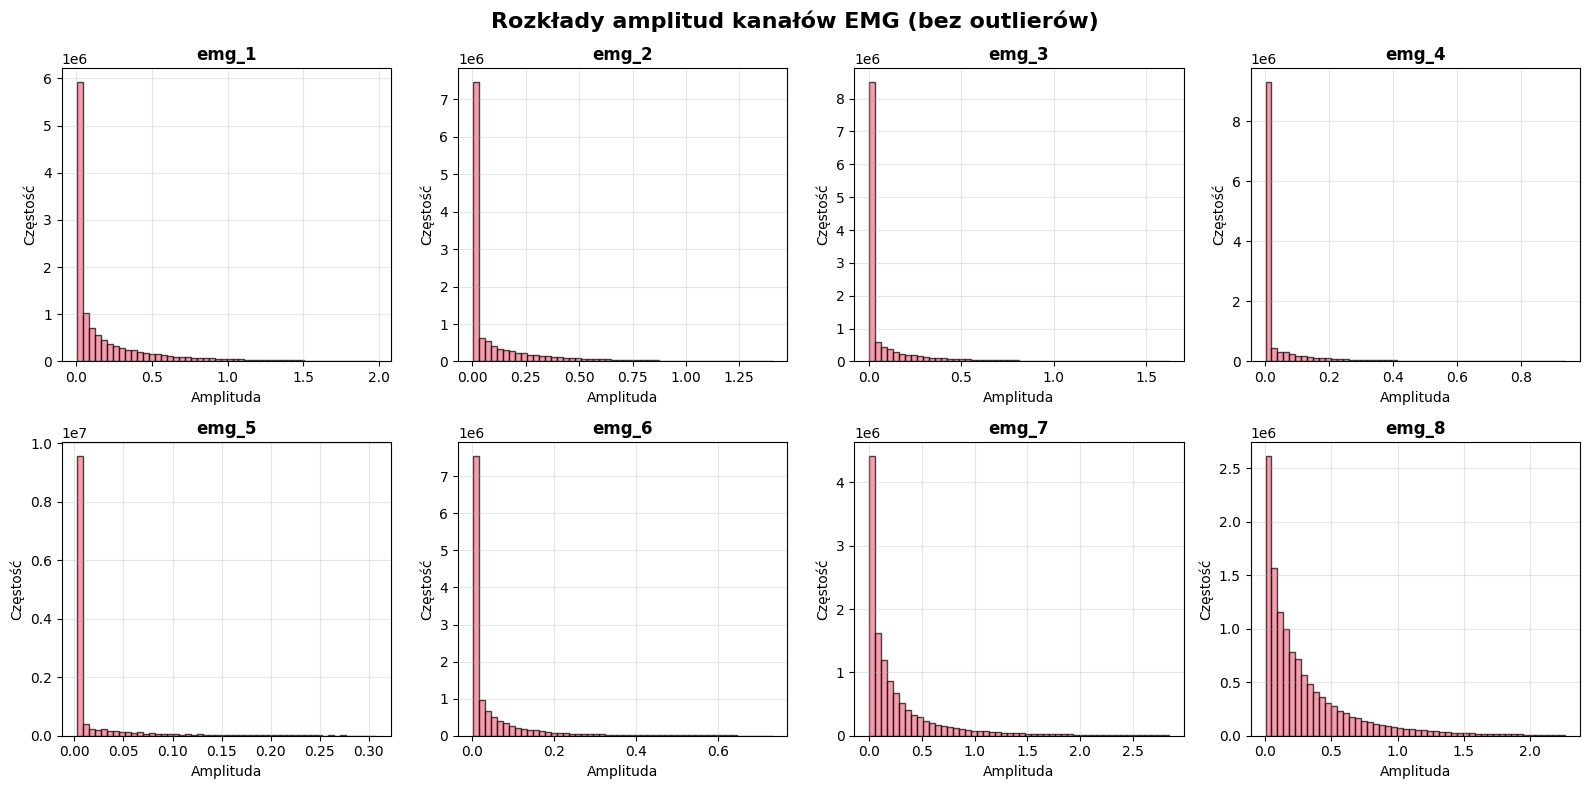


📈 PRZYKŁADOWE SYGNAŁY EMG
🔍 Pokazuję fragment od próbki 1155288 do 1156288
   Subject: 9
   Exercise: 3
   Stimulus: 15


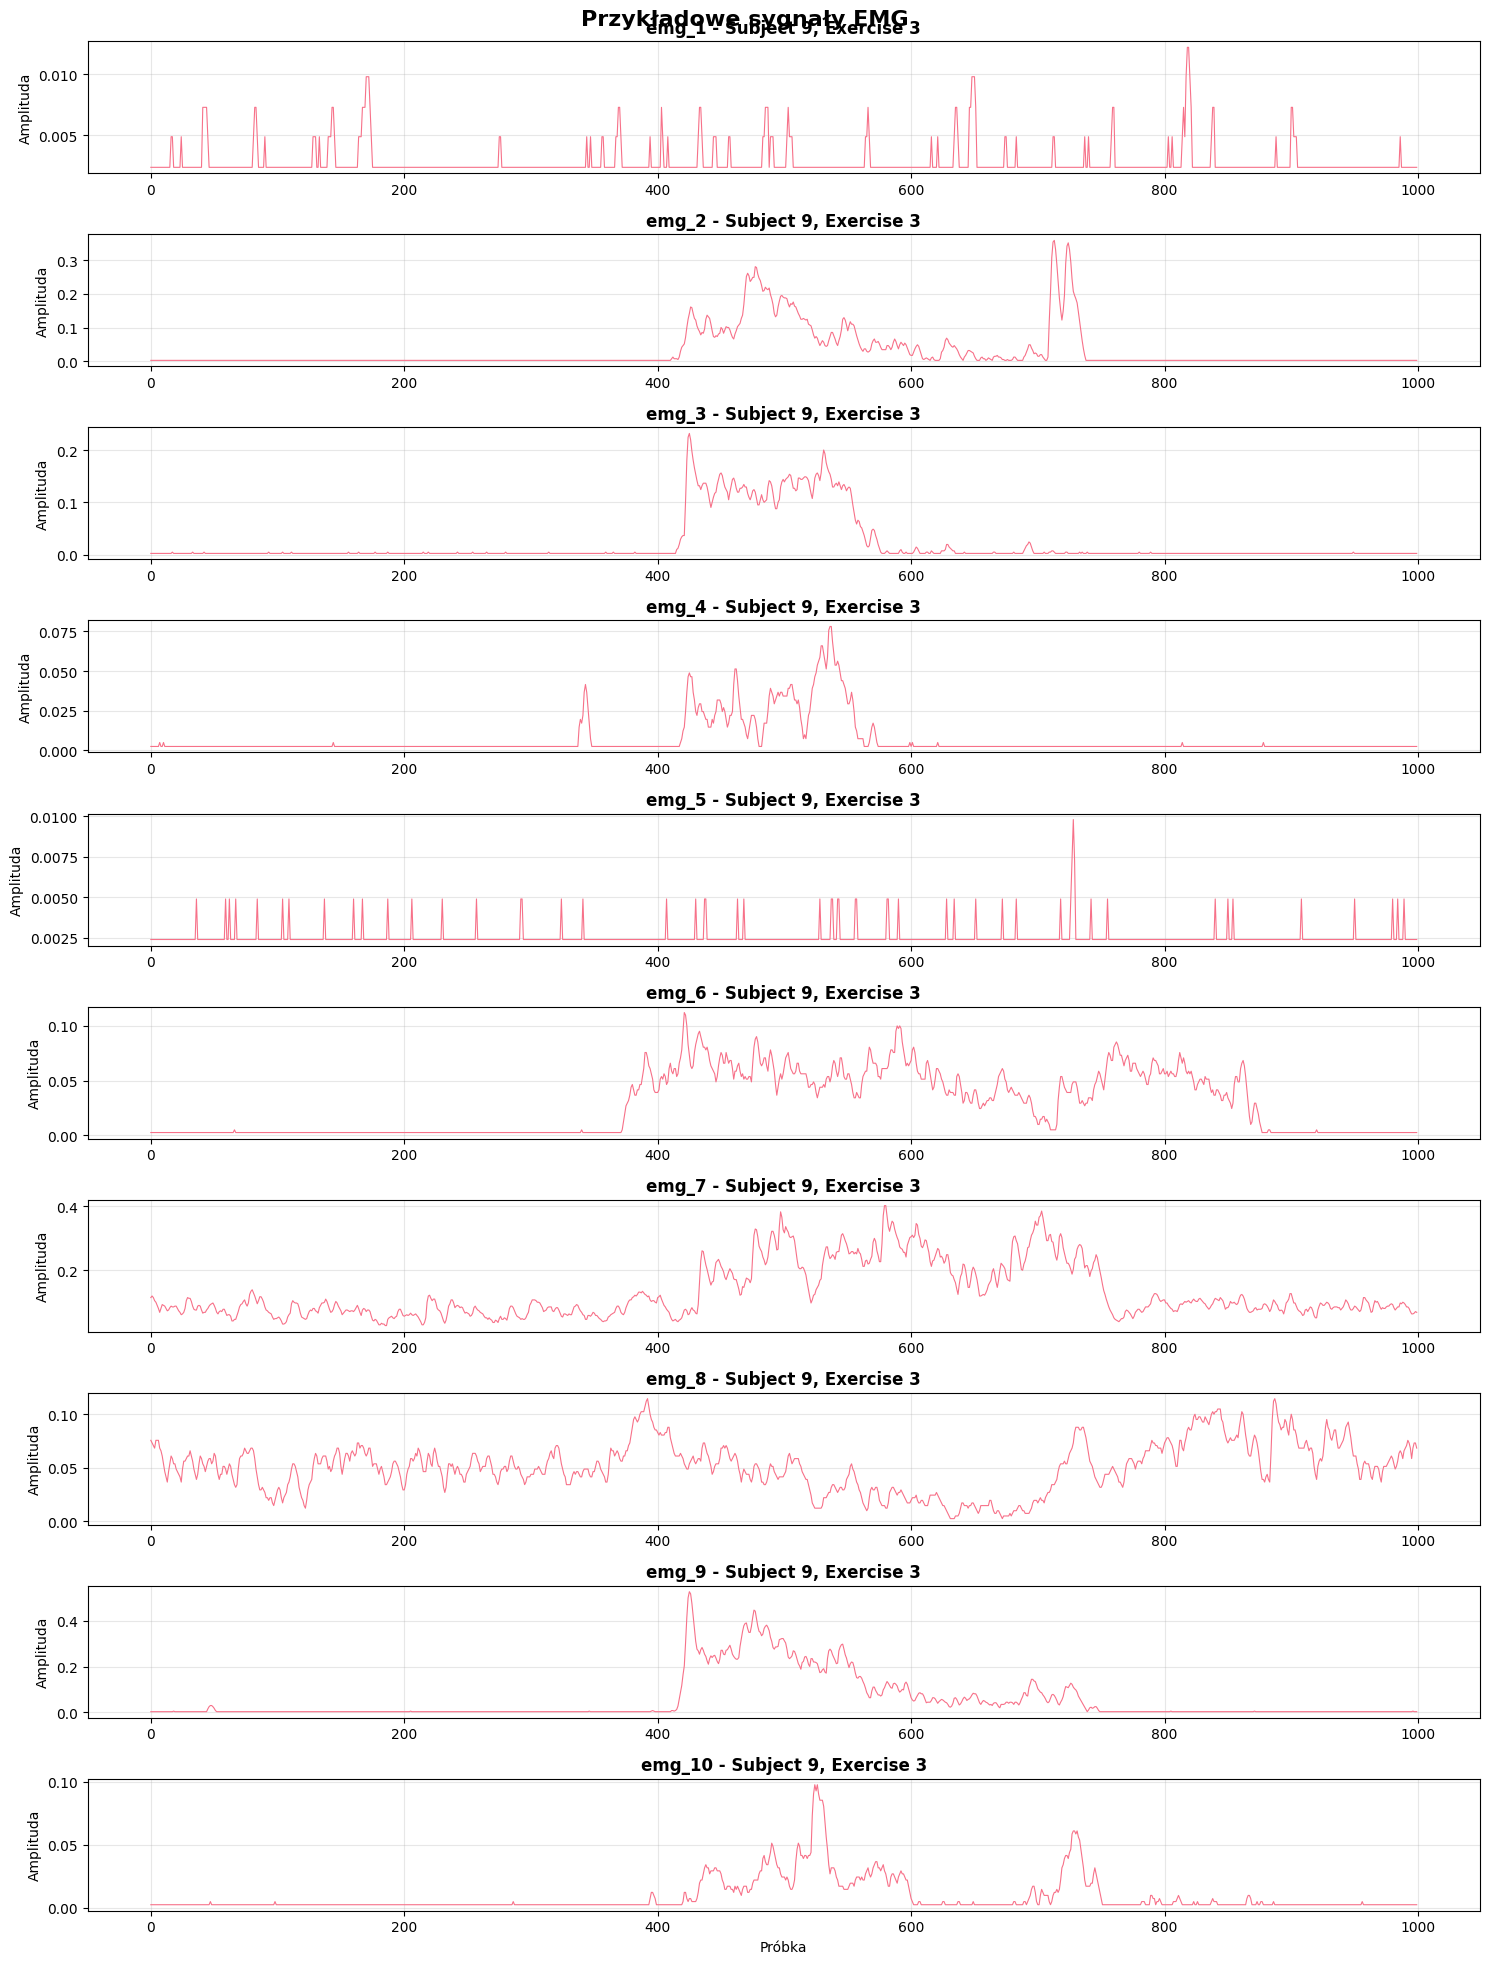


🔗 ANALIZA KORELACJI KANAŁÓW EMG
📊 Statystyki korelacji:
   Średnia korelacja: 0.421
   Max korelacja: 0.680
   Min korelacja: 0.187


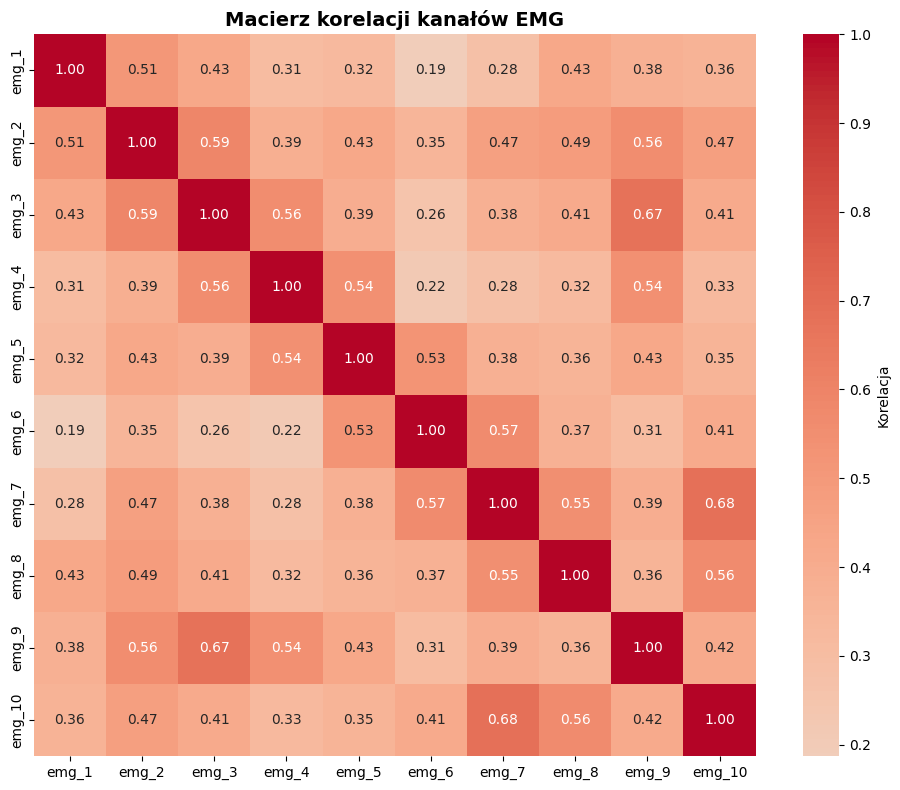


✅ ANALIZA EDA ZAKOŃCZONA!


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Ustaw styl wykresów
plt.style.use('default')
sns.set_palette("husl")

def load_final_dataset(file_path="/content/final_emg_dataset.parquet"):
    """Wczytaj finalne dane"""
    try:
        if Path(file_path).exists():
            df = pd.read_parquet(file_path)
            print(f"✅ Wczytano dane z {file_path}")
        else:
            # Spróbuj CSV jeśli parquet nie istnieje
            csv_path = "/content/final_emg_dataset.csv"
            if Path(csv_path).exists():
                df = pd.read_csv(csv_path)
                print(f"✅ Wczytano dane z {csv_path}")
            else:
                print("❌ Nie znaleziono pliku z danymi!")
                return None

        print(f"📊 Kształt danych: {df.shape}")
        return df
    except Exception as e:
        print(f"❌ Błąd wczytywania: {e}")
        return None

def basic_dataset_info(df):
    """Podstawowe informacje o datasecie"""
    print("="*60)
    print("📈 PODSTAWOWE INFORMACJE O DATASECIE")
    print("="*60)

    print(f"🔢 Liczba przykładów (wierszy): {len(df):,}")
    print(f"🔢 Liczba kolumn: {len(df.columns)}")
    print(f"💾 Rozmiar w pamięci: {df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

    # Znajdź kanały EMG
    emg_cols = [col for col in df.columns if col.startswith('emg_')]
    glove_cols = [col for col in df.columns if col.startswith('glove_')]

    print(f"📡 Liczba kanałów EMG: {len(emg_cols)}")
    print(f"🧤 Liczba sensorów rękawicy: {len(glove_cols)}")

    print(f"\n🏷️ Kolumny EMG: {emg_cols}")
    print(f"🏷️ Kolumny glove: {glove_cols[:5]}{'...' if len(glove_cols) > 5 else ''}")

    return emg_cols, glove_cols

def analyze_subjects_and_exercises(df):
    """Analiza uczestników i ćwiczeń"""
    print("\n" + "="*60)
    print("👥 ANALIZA UCZESTNIKÓW I ĆWICZEŃ")
    print("="*60)

    # Unikalne wartości
    unique_subjects = sorted(df['subject'].unique())
    unique_exercises = sorted(df['exercise'].unique())

    print(f"👤 Liczba uczestników: {len(unique_subjects)}")
    print(f"🏋️ Liczba typów ćwiczeń: {len(unique_exercises)}")

    print(f"\n👤 Lista uczestników: {unique_subjects}")
    print(f"🏋️ Lista ćwiczeń: {unique_exercises}")

    # Rozkład danych na uczestnika
    subject_counts = df['subject'].value_counts().sort_index()
    print(f"\n📊 Próbek na uczestnika:")
    for subject, count in subject_counts.items():
        print(f"   Subject {subject}: {count:,} próbek")

    # Rozkład danych na ćwiczenie (klasy/gesty)
    exercise_counts = df['exercise'].value_counts().sort_index()
    print(f"\n📊 Rozkład klas (gestów):")
    for exercise, count in exercise_counts.items():
        print(f"   Exercise {exercise}: {count:,} próbek ({count/len(df)*100:.1f}%)")

    return unique_subjects, unique_exercises, subject_counts, exercise_counts

def plot_class_distribution(df):
    """Wykres rozkładu klas"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Rozkład ćwiczeń
    exercise_counts = df['exercise'].value_counts().sort_index()
    axes[0].bar(exercise_counts.index, exercise_counts.values, alpha=0.7)
    axes[0].set_title('Rozkład klas (ćwiczeń/gestów)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('ID ćwiczenia')
    axes[0].set_ylabel('Liczba próbek')
    axes[0].grid(True, alpha=0.3)

    # Dodaj etykiety na słupkach
    for i, v in enumerate(exercise_counts.values):
        axes[0].text(exercise_counts.index[i], v + max(exercise_counts.values)*0.01,
                    f'{v:,}', ha='center', va='bottom', fontweight='bold')

    # Rozkład uczestników
    subject_counts = df['subject'].value_counts().sort_index()
    axes[1].bar(subject_counts.index, subject_counts.values, alpha=0.7, color='orange')
    axes[1].set_title('Rozkład próbek na uczestnika', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('ID uczestnika')
    axes[1].set_ylabel('Liczba próbek')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_signal_lengths(df):
    """Analiza długości sygnałów"""
    print("\n" + "="*60)
    print("📏 ANALIZA DŁUGOŚCI SYGNAŁÓW")
    print("="*60)

    # Grupuj po pliku źródłowym żeby znaleźć długości sygnałów
    signal_lengths = df.groupby(['source_zip', 'source_file']).size()

    print(f"📊 Statystyki długości sygnałów:")
    print(f"   Średnia długość: {signal_lengths.mean():.0f} próbek")
    print(f"   Mediana: {signal_lengths.median():.0f} próbek")
    print(f"   Min długość: {signal_lengths.min()} próbek")
    print(f"   Max długość: {signal_lengths.max()} próbek")
    print(f"   Odchylenie std: {signal_lengths.std():.0f} próbek")

    # Histogram długości sygnałów
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(signal_lengths.values, bins=30, alpha=0.7, edgecolor='black')
    plt.title('Histogram długości sygnałów', fontsize=14, fontweight='bold')
    plt.xlabel('Długość sygnału (liczba próbek)')
    plt.ylabel('Liczba sygnałów')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.boxplot(signal_lengths.values)
    plt.title('Boxplot długości sygnałów', fontsize=14, fontweight='bold')
    plt.ylabel('Długość sygnału (liczba próbek)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return signal_lengths

def analyze_emg_channels(df, emg_cols):
    """Analiza kanałów EMG"""
    print("\n" + "="*60)
    print("📡 ANALIZA KANAŁÓW EMG")
    print("="*60)

    # Podstawowe statystyki dla każdego kanału
    emg_stats = df[emg_cols].describe()
    print("📊 Statystyki opisowe kanałów EMG:")
    print(emg_stats.round(4))

    # Sprawdź czy są wartości zerowe lub NaN
    print(f"\n🔍 Jakość danych EMG:")
    for col in emg_cols:
        zeros = (df[col] == 0).sum()
        nans = df[col].isna().sum()
        print(f"   {col}: {zeros:,} zer ({zeros/len(df)*100:.2f}%), {nans} NaN")

    # Wykres rozkładów amplitud
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, col in enumerate(emg_cols):
        if i < len(axes):
            # Histogram z outlierami usuniętymi (99th percentile)
            data = df[col]
            q99 = data.quantile(0.99)
            q01 = data.quantile(0.01)
            filtered_data = data[(data >= q01) & (data <= q99)]

            axes[i].hist(filtered_data, bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{col}', fontweight='bold')
            axes[i].set_xlabel('Amplituda')
            axes[i].set_ylabel('Częstość')
            axes[i].grid(True, alpha=0.3)

    plt.suptitle('Rozkłady amplitud kanałów EMG (bez outlierów)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def show_sample_emg_signals(df, emg_cols, n_samples=1000):
    """Pokaż przykładowe sygnały EMG"""
    print("\n" + "="*60)
    print("📈 PRZYKŁADOWE SYGNAŁY EMG")
    print("="*60)

    # Wybierz losowy fragment
    start_idx = np.random.randint(0, len(df) - n_samples)
    sample_data = df.iloc[start_idx:start_idx + n_samples]

    print(f"🔍 Pokazuję fragment od próbki {start_idx} do {start_idx + n_samples}")
    print(f"   Subject: {sample_data['subject'].iloc[0]}")
    print(f"   Exercise: {sample_data['exercise'].iloc[0]}")
    print(f"   Stimulus: {sample_data['stimulus'].iloc[0]}")

    # Wykres sygnałów EMG
    fig, axes = plt.subplots(len(emg_cols), 1, figsize=(15, 2*len(emg_cols)))

    for i, col in enumerate(emg_cols):
        if len(emg_cols) == 1:
            ax = axes
        else:
            ax = axes[i]

        ax.plot(sample_data[col].values, linewidth=0.8)
        ax.set_title(f'{col} - Subject {sample_data["subject"].iloc[0]}, Exercise {sample_data["exercise"].iloc[0]}',
                    fontweight='bold')
        ax.set_ylabel('Amplituda')
        ax.grid(True, alpha=0.3)

        if i == len(emg_cols) - 1:
            ax.set_xlabel('Próbka')

    plt.suptitle('Przykładowe sygnały EMG', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def correlation_analysis(df, emg_cols):
    """Analiza korelacji między kanałami"""
    print("\n" + "="*60)
    print("🔗 ANALIZA KORELACJI KANAŁÓW EMG")
    print("="*60)

    # Macierz korelacji
    corr_matrix = df[emg_cols].corr()

    print("📊 Statystyki korelacji:")
    # Usuń przekątną (korelację ze sobą)
    corr_values = corr_matrix.values
    corr_values = corr_values[np.triu_indices_from(corr_values, k=1)]

    print(f"   Średnia korelacja: {corr_values.mean():.3f}")
    print(f"   Max korelacja: {corr_values.max():.3f}")
    print(f"   Min korelacja: {corr_values.min():.3f}")

    # Heatmapa korelacji
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'label': 'Korelacja'})
    plt.title('Macierz korelacji kanałów EMG', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def run_complete_eda():
    """Uruchom pełną analizę EDA"""
    print("🚀 ROZPOCZYNAM PEŁNĄ ANALIZĘ EDA")
    print("="*60)

    # Wczytaj dane
    df = load_final_dataset()
    if df is None:
        return

    # Podstawowe info
    emg_cols, glove_cols = basic_dataset_info(df)

    # Analiza uczestników i ćwiczeń
    subjects, exercises, subject_counts, exercise_counts = analyze_subjects_and_exercises(df)

    # Wykres rozkładu klas
    plot_class_distribution(df)

    # Analiza długości sygnałów
    signal_lengths = analyze_signal_lengths(df)

    # Analiza kanałów EMG
    analyze_emg_channels(df, emg_cols)

    # Przykładowe sygnały
    show_sample_emg_signals(df, emg_cols)

    # Analiza korelacji
    correlation_analysis(df, emg_cols)

    print("\n" + "="*60)
    print("✅ ANALIZA EDA ZAKOŃCZONA!")
    print("="*60)

    return df

# Uruchom analizę
df = run_complete_eda()

🚀 MEMORY-OPTIMIZED PREPROCESSING
🔧 Memory-Optimized EMG Preprocessor:
   Window size: 200 próbek
   Overlap: 50.0% (100 próbek step)
   Normalizacja: z-score
💾 RAM: 59.1% używane, 5.2 GB dostępne

🔄 Obliczanie globalnych statystyk dla normalizacji...
📡 Znaleziono 10 kanałów EMG
🧤 Znaleziono 22 sensorów glove
   Wczytywanie pliku parquet...
   Przetwarzam chunk 20/252...
💾 RAM: 91.6% używane, 1.1 GB dostępne
⚠️ Wysoki poziom RAM - uruchamiam garbage collection
   Przetwarzam chunk 40/252...
💾 RAM: 91.6% używane, 1.1 GB dostępne
⚠️ Wysoki poziom RAM - uruchamiam garbage collection
   Przetwarzam chunk 60/252...
💾 RAM: 91.5% używane, 1.1 GB dostępne
⚠️ Wysoki poziom RAM - uruchamiam garbage collection
   Przetwarzam chunk 80/252...
💾 RAM: 91.5% używane, 1.1 GB dostępne
⚠️ Wysoki poziom RAM - uruchamiam garbage collection
   Przetwarzam chunk 100/252...
💾 RAM: 91.5% używane, 1.1 GB dostępne
⚠️ Wysoki poziom RAM - uruchamiam garbage collection
   Przetwarzam chunk 120/252...
💾 RAM: 91.5% uż

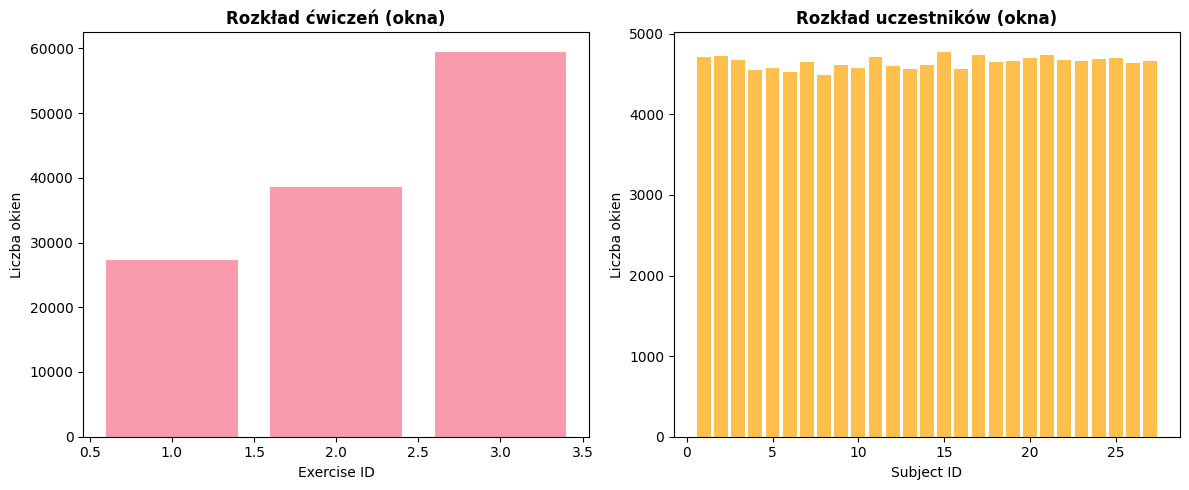


✅ PREPROCESSING ZAKOŃCZONY!
   Dane w: /content/segmented_data
   Łącznie okien: 125,409

🔍 Przykład wczytania pierwszego batch-a:
📂 Wczytywanie batch-ów: [0]
  📄 Wczytywanie: batch_0.npz
✅ Wczytano dane: X=(4241, 200, 32), y=(4241, 4)
Przykładowe dane: X=(4241, 200, 32)
Pierwsze okno: Subject=23, Exercise=3


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pathlib import Path
import os
import gc
import json

class MemoryOptimizedEMGPreprocessor:
    """Preprocessing EMG zoptymalizowany pod kątem pamięci"""

    def __init__(self, window_size=200, overlap=0.5, normalization='z-score'):
        self.window_size = window_size
        self.overlap = overlap
        self.step_size = int(window_size * (1 - overlap))
        self.normalization = normalization
        self.scalers = {}
        self.emg_cols = []
        self.glove_cols = []

        print(f"🔧 Memory-Optimized EMG Preprocessor:")
        print(f"   Window size: {window_size} próbek")
        print(f"   Overlap: {overlap*100}% ({self.step_size} próbek step)")
        print(f"   Normalizacja: {normalization}")

    def check_memory(self):
        """Sprawdź dostępną pamięć"""
        try:
            import psutil
            ram = psutil.virtual_memory()
            print(f"💾 RAM: {ram.percent:.1f}% używane, {ram.available / (1024**3):.1f} GB dostępne")
            if ram.percent > 85:
                print("⚠️ Wysoki poziom RAM - uruchamiam garbage collection")
                gc.collect()
        except ImportError:
            pass

    def compute_global_stats(self, file_path="/content/final_emg_dataset.parquet"):
        """Oblicz globalne statystyki do normalizacji (bez wczytywania wszystkich danych)"""
        print(f"\n🔄 Obliczanie globalnych statystyk dla normalizacji...")

        # Check if file exists and determine format
        parquet_path = Path(file_path)
        csv_path = Path(file_path.replace('.parquet', '.csv'))

        # Wczytaj tylko próbkę żeby znaleźć kolumny
        if parquet_path.exists():
            # For parquet, read small chunk differently
            sample_df = pd.read_parquet(parquet_path)
            if len(sample_df) > 1000:
                sample_df = sample_df.head(1000)
        elif csv_path.exists():
            sample_df = pd.read_csv(csv_path, nrows=1000)
        else:
            print(f"❌ Nie znaleziono pliku: {file_path} ani {csv_path}")
            return

        self.emg_cols = [col for col in sample_df.columns if col.startswith('emg_')]
        self.glove_cols = [col for col in sample_df.columns if col.startswith('glove_')]
        signal_cols = self.emg_cols + self.glove_cols

        print(f"📡 Znaleziono {len(self.emg_cols)} kanałów EMG")
        print(f"🧤 Znaleziono {len(self.glove_cols)} sensorów glove")

        if self.normalization == 'none':
            print("   Pominięto obliczanie statystyk")
            return

        # Oblicz statystyki w chunk-ach
        chunk_size = 50000
        sums = {col: 0.0 for col in signal_cols}
        sums_sq = {col: 0.0 for col in signal_cols}
        mins = {col: float('inf') for col in signal_cols}
        maxs = {col: float('-inf') for col in signal_cols}
        total_samples = 0

        # Iteruj przez dane w chunk-ach
        try:
            if parquet_path.exists():
                # For parquet files, we need to read in chunks differently
                # Read the entire file but process in chunks in memory
                print("   Wczytywanie pliku parquet...")
                full_df = pd.read_parquet(parquet_path)

                # Process in chunks
                num_chunks = len(full_df) // chunk_size + 1
                for i in range(num_chunks):
                    start_idx = i * chunk_size
                    end_idx = min((i + 1) * chunk_size, len(full_df))

                    if start_idx >= len(full_df):
                        break

                    chunk = full_df.iloc[start_idx:end_idx]

                    if (i + 1) % 20 == 0:
                        print(f"   Przetwarzam chunk {i + 1}/{num_chunks}...")
                        self.check_memory()

                    for col in signal_cols:
                        if col in chunk.columns:
                            data = chunk[col].values.astype(np.float32)
                            sums[col] += np.sum(data)
                            sums_sq[col] += np.sum(data ** 2)
                            mins[col] = min(mins[col], np.min(data))
                            maxs[col] = max(maxs[col], np.max(data))

                    total_samples += len(chunk)

                # Clean up
                del full_df
                gc.collect()

            else:
                # Use CSV chunking
                df_iterator = pd.read_csv(csv_path, chunksize=chunk_size)
                chunk_count = 0
                for chunk in df_iterator:
                    chunk_count += 1
                    if chunk_count % 20 == 0:
                        print(f"   Przetwarzam chunk {chunk_count}...")
                        self.check_memory()

                    for col in signal_cols:
                        if col in chunk.columns:
                            data = chunk[col].values.astype(np.float32)
                            sums[col] += np.sum(data)
                            sums_sq[col] += np.sum(data ** 2)
                            mins[col] = min(mins[col], np.min(data))
                            maxs[col] = max(maxs[col], np.max(data))

                    total_samples += len(chunk)

        except Exception as e:
            print(f"❌ Błąd przy wczytywaniu danych: {e}")
            return

        # Oblicz finalne statystyki i stwórz scalery
        for col in signal_cols:
            if sums[col] == 0:  # Skip columns with no data
                continue

            mean = sums[col] / total_samples
            variance = (sums_sq[col] / total_samples) - (mean ** 2)
            std = np.sqrt(max(variance, 1e-8))  # Zabezpieczenie przed zerem

            if self.normalization == 'z-score':
                scaler = StandardScaler()
                scaler.mean_ = np.array([mean])
                scaler.scale_ = np.array([std])
            elif self.normalization == 'min-max':
                scaler = MinMaxScaler()
                scaler.data_min_ = np.array([mins[col]])
                scaler.data_max_ = np.array([maxs[col]])
                scaler.data_range_ = np.array([maxs[col] - mins[col]])
                scaler.scale_ = np.array([1.0 / max(scaler.data_range_[0], 1e-8)])
                scaler.min_ = np.array([-mins[col] * scaler.scale_[0]])

            self.scalers[col] = scaler

        print(f"   ✅ Obliczono statystyki dla {len(self.scalers)} kanałów")
        print(f"   📊 Łącznie próbek: {total_samples:,}")

    def process_single_signal_batch(self, input_dir="/content/processed_data",
                                   output_dir="/content/segmented_data", batch_size=5):
        """Przetwarza pliki parquet jeden po drugim"""

        os.makedirs(output_dir, exist_ok=True)

        # Znajdź wszystkie przetworzone pliki
        parquet_files = list(Path(input_dir).glob("*.parquet"))
        if not parquet_files:
            # Try CSV files as fallback
            csv_files = list(Path(input_dir).glob("*.csv"))
            if not csv_files:
                print("❌ Nie znaleziono plików parquet ani csv do przetworzenia!")
                return None, 0, None
            parquet_files = csv_files

        print(f"📁 Znaleziono {len(parquet_files)} plików do segmentacji")

        # Statystyki globalne
        total_windows = 0
        all_labels = []
        all_metadata = []
        batch_files = []

        # Przetwarzaj w małych batch-ach
        for batch_idx in range(0, len(parquet_files), batch_size):
            batch = parquet_files[batch_idx:batch_idx + batch_size]
            print(f"\n📦 Batch {batch_idx//batch_size + 1}: {len(batch)} plików")

            batch_windows = []
            batch_labels = []
            batch_metadata = []

            for file_path in batch:
                print(f"  📄 Przetwarzam: {file_path.name}")

                try:
                    # Wczytaj pojedynczy plik
                    if file_path.suffix == '.parquet':
                        signal_df = pd.read_parquet(file_path)
                    else:
                        signal_df = pd.read_csv(file_path)

                    # Normalizuj sygnały
                    if self.normalization != 'none':
                        for col in self.emg_cols + self.glove_cols:
                            if col in signal_df.columns and col in self.scalers:
                                signal_df[col] = self.scalers[col].transform(
                                    signal_df[col].values.reshape(-1, 1)
                                ).flatten()

                    # Segmentuj na okna
                    windows, labels, metadata = self._segment_single_signal(
                        signal_df, file_path.stem
                    )

                    if len(windows) > 0:
                        batch_windows.extend(windows)
                        batch_labels.extend(labels)
                        batch_metadata.extend(metadata)
                        print(f"    ✅ {len(windows)} okien")
                    else:
                        print(f"    ⚠️ Brak okien (plik za krótki?)")

                    # Wyczyść pamięć
                    del signal_df
                    gc.collect()

                except Exception as e:
                    print(f"    ❌ Błąd przetwarzania {file_path.name}: {e}")
                    continue

            # Zapisz batch jeśli nie jest pusty
            if batch_windows:
                batch_X = np.array(batch_windows, dtype=np.float32)
                batch_y = pd.DataFrame(batch_labels)
                batch_meta = pd.DataFrame(batch_metadata)

                # Zapisz batch
                batch_file = f"{output_dir}/batch_{batch_idx//batch_size}.npz"
                np.savez_compressed(
                    batch_file,
                    X=batch_X,
                    y=batch_y.to_dict('records'),
                    meta=batch_meta.to_dict('records')
                )

                batch_files.append(batch_file)
                total_windows += len(batch_X)
                all_labels.extend(batch_labels)
                all_metadata.extend(batch_metadata)

                print(f"    💾 Zapisano batch: {batch_X.shape}")

                # Wyczyść pamięć
                del batch_windows, batch_X, batch_y, batch_meta
                gc.collect()
                self.check_memory()
            else:
                print(f"    ⚠️ Pusty batch - pomijam")

        # Zapisz metadane
        if all_labels:
            final_labels = pd.DataFrame(all_labels)
            final_metadata = pd.DataFrame(all_metadata)

            final_labels.to_csv(f"{output_dir}/all_labels.csv", index=False)
            final_metadata.to_csv(f"{output_dir}/all_metadata.csv", index=False)

            # Zapisz info o batch-ach
            batch_info = {
                'total_windows': total_windows,
                'num_batches': len(batch_files),
                'batch_files': [os.path.basename(f) for f in batch_files],
                'window_size': self.window_size,
                'overlap': self.overlap,
                'normalization': self.normalization,
                'emg_cols': self.emg_cols,
                'glove_cols': self.glove_cols
            }

            with open(f"{output_dir}/batch_info.json", 'w') as f:
                json.dump(batch_info, f, indent=2)

            print(f"\n✅ Przetwarzanie zakończone!")
            print(f"   Łącznie okien: {total_windows:,}")
            print(f"   Liczba batch-ów: {len(batch_files)}")
            print(f"   Zapisano w: {output_dir}")

            return output_dir, total_windows, final_labels
        else:
            print("❌ Brak danych do zapisania!")

        return None, 0, None

    def _segment_single_signal(self, signal_df, file_name):
        """Segmentuj pojedynczy sygnał"""
        signal_cols = self.emg_cols + self.glove_cols
        available_cols = [col for col in signal_cols if col in signal_df.columns]

        if not available_cols:
            print(f"    ⚠️ Brak kolumn sygnałów w {file_name}")
            return [], [], []

        signal_length = len(signal_df)
        if signal_length < self.window_size:
            print(f"    ⚠️ Sygnał za krótki: {signal_length} < {self.window_size}")
            return [], [], []

        windows = []
        labels = []
        metadata = []

        signal_data = signal_df[available_cols].values.astype(np.float32)

        for start_idx in range(0, signal_length - self.window_size + 1, self.step_size):
            end_idx = start_idx + self.window_size

            # Wyciągnij okno
            window_data = signal_data[start_idx:end_idx]
            windows.append(window_data)

            # Etykieta ze środka okna
            middle_idx = start_idx + self.window_size // 2
            window_label = signal_df.iloc[middle_idx]

            # Sprawdź czy wymagane kolumny istnieją
            subject = window_label.get('subject', 0)
            exercise = window_label.get('exercise', 0)
            stimulus = window_label.get('stimulus', 0)
            repetition = window_label.get('repetition', 0)

            labels.append({
                'subject': int(subject) if pd.notna(subject) else 0,
                'exercise': int(exercise) if pd.notna(exercise) else 0,
                'stimulus': int(stimulus) if pd.notna(stimulus) else 0,
                'repetition': int(repetition) if pd.notna(repetition) else 0
            })

            metadata.append({
                'source_file': file_name,
                'window_start': start_idx,
                'window_end': end_idx,
                'num_channels': len(available_cols)
            })

        return windows, labels, metadata

    def load_batch_data(self, batch_dir="/content/segmented_data", batch_indices=None):
        """Wczytaj wybrane batch-e danych"""
        batch_info_path = f"{batch_dir}/batch_info.json"

        if not os.path.exists(batch_info_path):
            print("❌ Nie znaleziono info o batch-ach!")
            return None, None, None

        with open(batch_info_path, 'r') as f:
            batch_info = json.load(f)

        batch_files = batch_info['batch_files']

        if batch_indices is None:
            batch_indices = range(len(batch_files))

        print(f"📂 Wczytywanie batch-ów: {list(batch_indices)}")

        all_X = []
        all_y = []
        all_meta = []

        for i in batch_indices:
            if i < len(batch_files):
                batch_path = f"{batch_dir}/{batch_files[i]}"
                if os.path.exists(batch_path):
                    print(f"  📄 Wczytywanie: {batch_files[i]}")

                    data = np.load(batch_path, allow_pickle=True)
                    all_X.append(data['X'])
                    all_y.extend(data['y'])
                    all_meta.extend(data['meta'])
                else:
                    print(f"  ⚠️ Nie znaleziono: {batch_files[i]}")

        if all_X:
            X = np.concatenate(all_X, axis=0)
            y = pd.DataFrame(all_y)
            meta = pd.DataFrame(all_meta)

            print(f"✅ Wczytano dane: X={X.shape}, y={y.shape}")
            return X, y, meta

        return None, None, None

    def quick_analysis(self, batch_dir="/content/segmented_data"):
        """Szybka analiza bez wczytywania wszystkich danych"""
        labels_path = f"{batch_dir}/all_labels.csv"

        if not os.path.exists(labels_path):
            print("❌ Nie znaleziono pliku z etykietami!")
            return

        print(f"\n📊 SZYBKA ANALIZA SEGMENTACJI")
        print("="*50)

        labels = pd.read_csv(labels_path)

        print(f"🪟 Łączna liczba okien: {len(labels):,}")

        print(f"\n👥 Okna na uczestnika:")
        subject_counts = labels['subject'].value_counts().sort_index()
        for subject, count in subject_counts.items():
            print(f"   Subject {subject}: {count:,} okien")

        print(f"\n🏋️ Okna na ćwiczenie:")
        exercise_counts = labels['exercise'].value_counts().sort_index()
        for exercise, count in exercise_counts.items():
            print(f"   Exercise {exercise}: {count:,} okien ({count/len(labels)*100:.1f}%)")

        # Prosty wykres
        try:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            axes[0].bar(exercise_counts.index, exercise_counts.values, alpha=0.7)
            axes[0].set_title('Rozkład ćwiczeń (okna)', fontweight='bold')
            axes[0].set_xlabel('Exercise ID')
            axes[0].set_ylabel('Liczba okien')

            axes[1].bar(subject_counts.index, subject_counts.values, alpha=0.7, color='orange')
            axes[1].set_title('Rozkład uczestników (okna)', fontweight='bold')
            axes[1].set_xlabel('Subject ID')
            axes[1].set_ylabel('Liczba okien')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"⚠️ Nie można wyświetlić wykresów: {e}")

def run_memory_optimized_preprocessing(window_size=200, overlap=0.5, normalization='z-score',
                                     input_file="/content/final_emg_dataset.parquet",
                                     input_dir="/content/processed_data"):
    """Uruchom preprocessing oszczędzający pamięć"""

    print("🚀 MEMORY-OPTIMIZED PREPROCESSING")
    print("="*50)

    preprocessor = MemoryOptimizedEMGPreprocessor(
        window_size=window_size,
        overlap=overlap,
        normalization=normalization
    )

    # Sprawdź pamięć
    preprocessor.check_memory()

    # Oblicz globalne statystyki
    preprocessor.compute_global_stats(input_file)

    # Przetwarza po batch-ach
    output_dir, total_windows, labels = preprocessor.process_single_signal_batch(
        input_dir=input_dir,
        batch_size=3  # Zmniejszony batch size
    )

    if output_dir and total_windows > 0:
        # Szybka analiza
        preprocessor.quick_analysis(output_dir)

        print(f"\n✅ PREPROCESSING ZAKOŃCZONY!")
        print(f"   Dane w: {output_dir}")
        print(f"   Łącznie okien: {total_windows:,}")

        return preprocessor, output_dir
    else:
        print("❌ Preprocessing nieudany - sprawdź ścieżki do plików")

    return None, None

# Przykład użycia:
if __name__ == "__main__":
    # Uruchom preprocessing
    preprocessor, output_dir = run_memory_optimized_preprocessing(
        window_size=200,
        overlap=0.5,
        normalization='z-score',
        input_file="/content/final_emg_dataset.parquet",  # Plik do statystyk
        input_dir="/content/processed_data"               # Folder z plikami do segmentacji
    )

    # Przykład wczytania części danych do testów
    if output_dir:
        print(f"\n🔍 Przykład wczytania pierwszego batch-a:")
        X_sample, y_sample, meta_sample = preprocessor.load_batch_data(
            output_dir,
            batch_indices=[0]  # Tylko pierwszy batch
        )

        if X_sample is not None:
            print(f"Przykładowe dane: X={X_sample.shape}")
            print(f"Pierwsze okno: Subject={y_sample.iloc[0]['subject']}, Exercise={y_sample.iloc[0]['exercise']}")
        else:
            print("❌ Nie udało się wczytać danych próbkowych")

📊 EMG EDA ANALYSIS TOOL
📋 Wczytano etykiety: (125409, 4)
   Dostępne kolumny: ['subject', 'exercise', 'stimulus', 'repetition']
📋 Wczytano metadane: (125409, 4)
📊 EMG EDA Analyzer zainicjalizowany
   Katalog: /content/segmented_data
   Łączne okna: 125,409
   Rozmiar okna: 200
   Overlap: 0.5
🚀 ROZPOCZYNAM KOMPLETNĄ ANALIZĘ EDA

📏 ANALIZA DŁUGOŚCI OKIEN
🪟 Parametry okien:
   Rozmiar okna: 200 próbek
   Overlap: 50.0%
   Krok: 100 próbek
   Łączna liczba okien: 125,409

📁 Pliki źródłowe:
   Liczba plików: 81


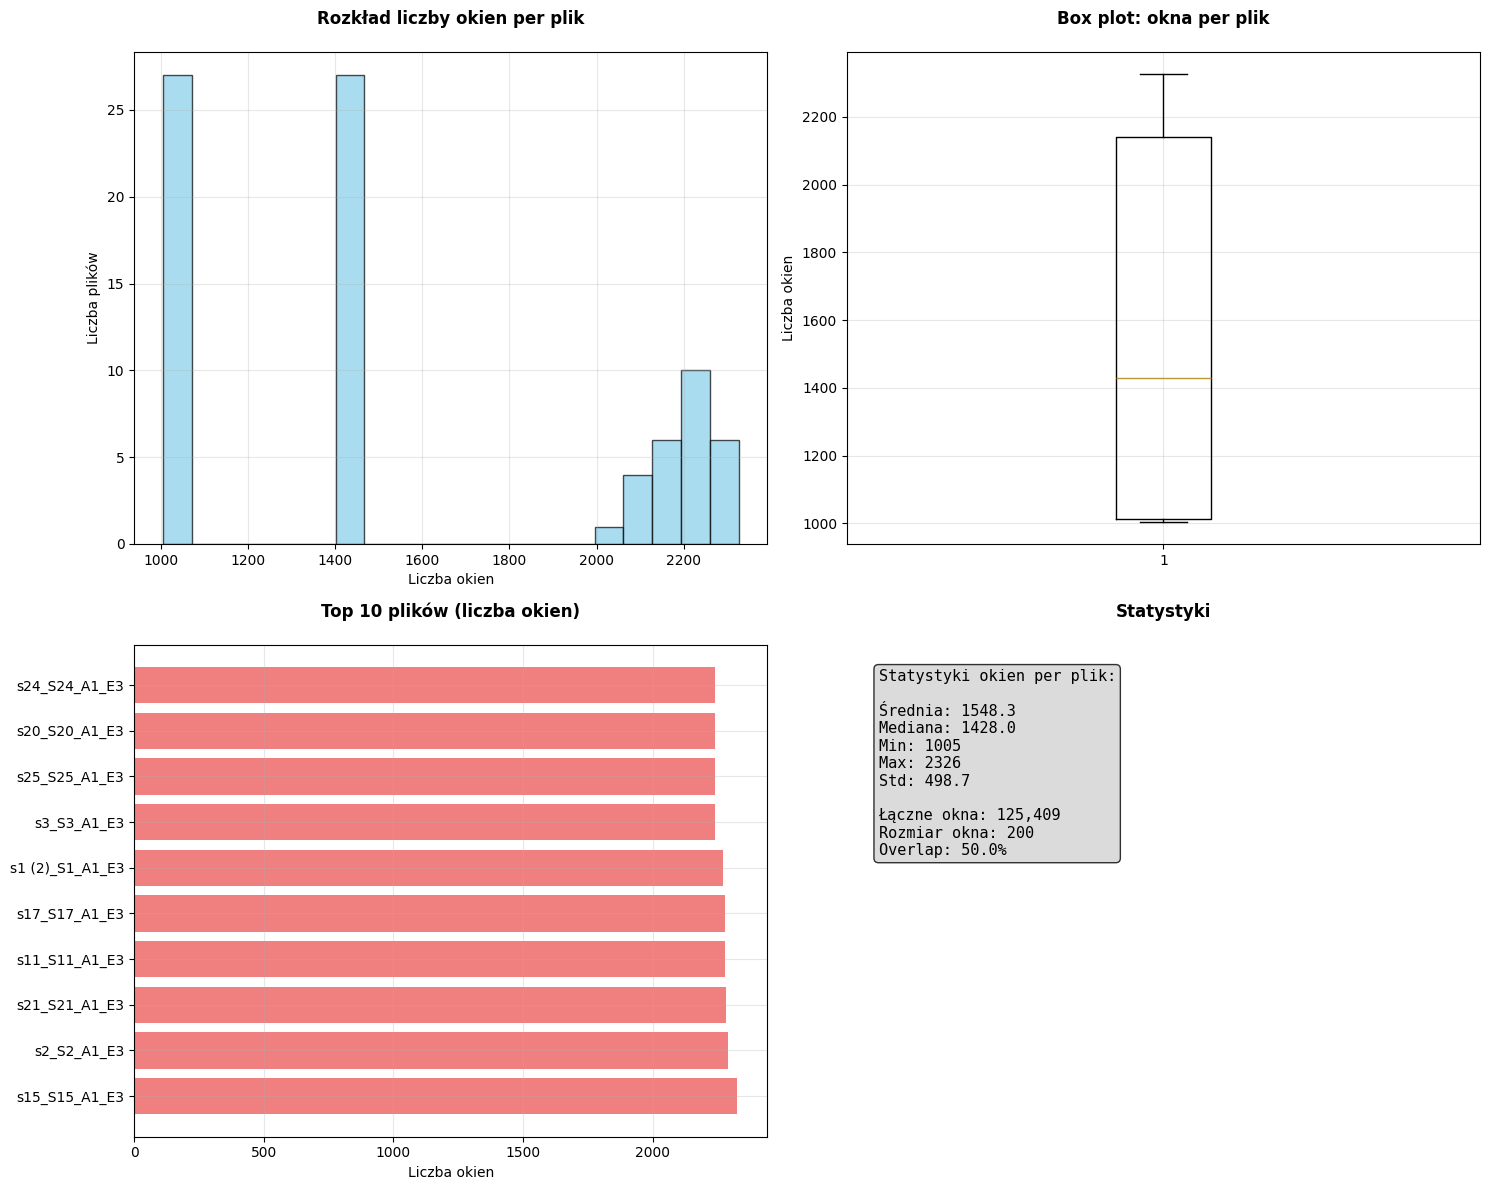


📊 Statystyki okien per plik:
   Średnia: 1548.3 okien/plik
   Mediana: 1428.0 okien/plik
   Min-Max: 1005 - 2326 okien

🎯 ANALIZA ROZKŁADU KLAS
📋 Dostępne kolumny: ['subject', 'exercise', 'stimulus', 'repetition']
🔍 Mapowanie kolumn: {'subject': 'subject', 'exercise': 'exercise', 'stimulus': 'stimulus'}


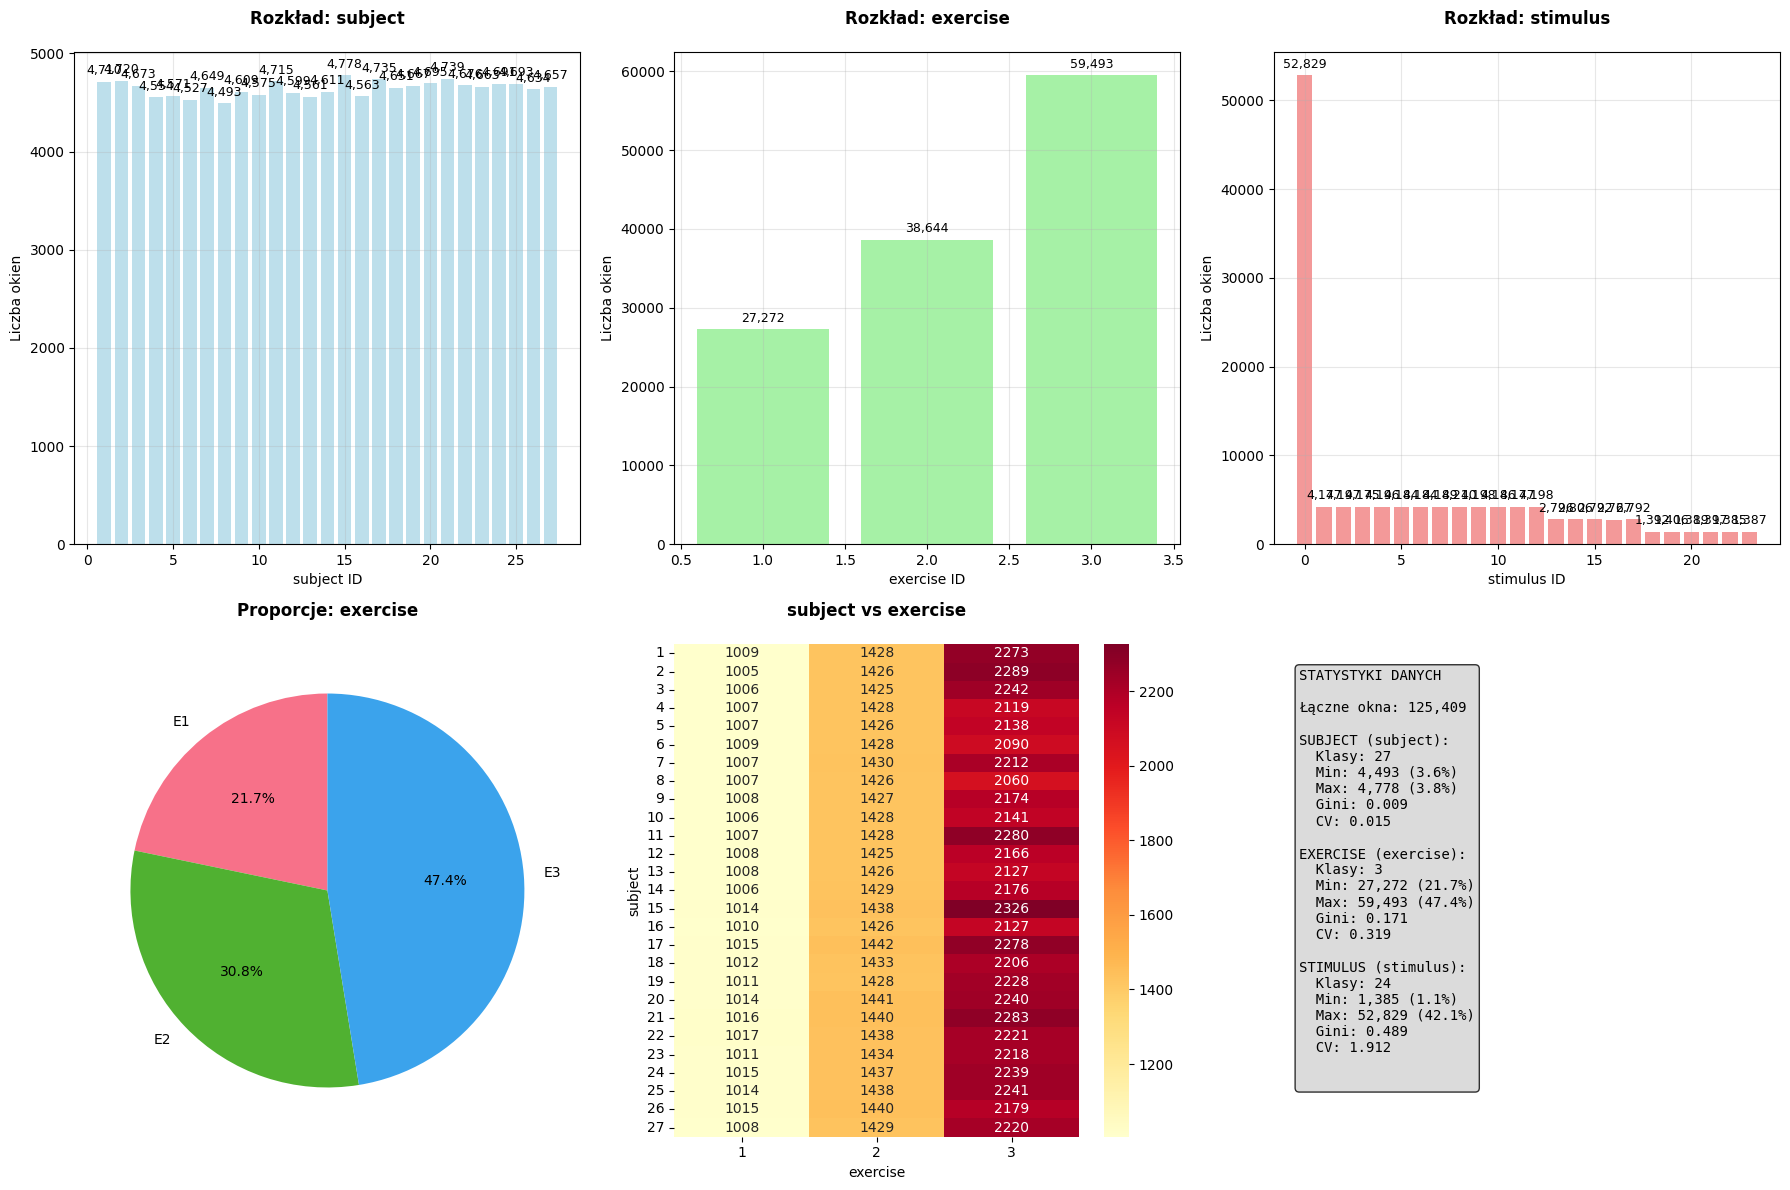


📊 SZCZEGÓŁOWE STATYSTYKI KLAS:

SUBJECT (subject):
   subject 1: 4,710 okien (3.8%)
   subject 2: 4,720 okien (3.8%)
   subject 3: 4,673 okien (3.7%)
   subject 4: 4,554 okien (3.6%)
   subject 5: 4,571 okien (3.6%)
   subject 6: 4,527 okien (3.6%)
   subject 7: 4,649 okien (3.7%)
   subject 8: 4,493 okien (3.6%)
   subject 9: 4,609 okien (3.7%)
   subject 10: 4,575 okien (3.6%)
   subject 11: 4,715 okien (3.8%)
   subject 12: 4,599 okien (3.7%)
   subject 13: 4,561 okien (3.6%)
   subject 14: 4,611 okien (3.7%)
   subject 15: 4,778 okien (3.8%)
   subject 16: 4,563 okien (3.6%)
   subject 17: 4,735 okien (3.8%)
   subject 18: 4,651 okien (3.7%)
   subject 19: 4,667 okien (3.7%)
   subject 20: 4,695 okien (3.7%)
   subject 21: 4,739 okien (3.8%)
   subject 22: 4,676 okien (3.7%)
   subject 23: 4,663 okien (3.7%)
   subject 24: 4,691 okien (3.7%)
   subject 25: 4,693 okien (3.7%)
   subject 26: 4,634 okien (3.7%)
   subject 27: 4,657 okien (3.7%)

EXERCISE (exercise):
   exercise 1: 27

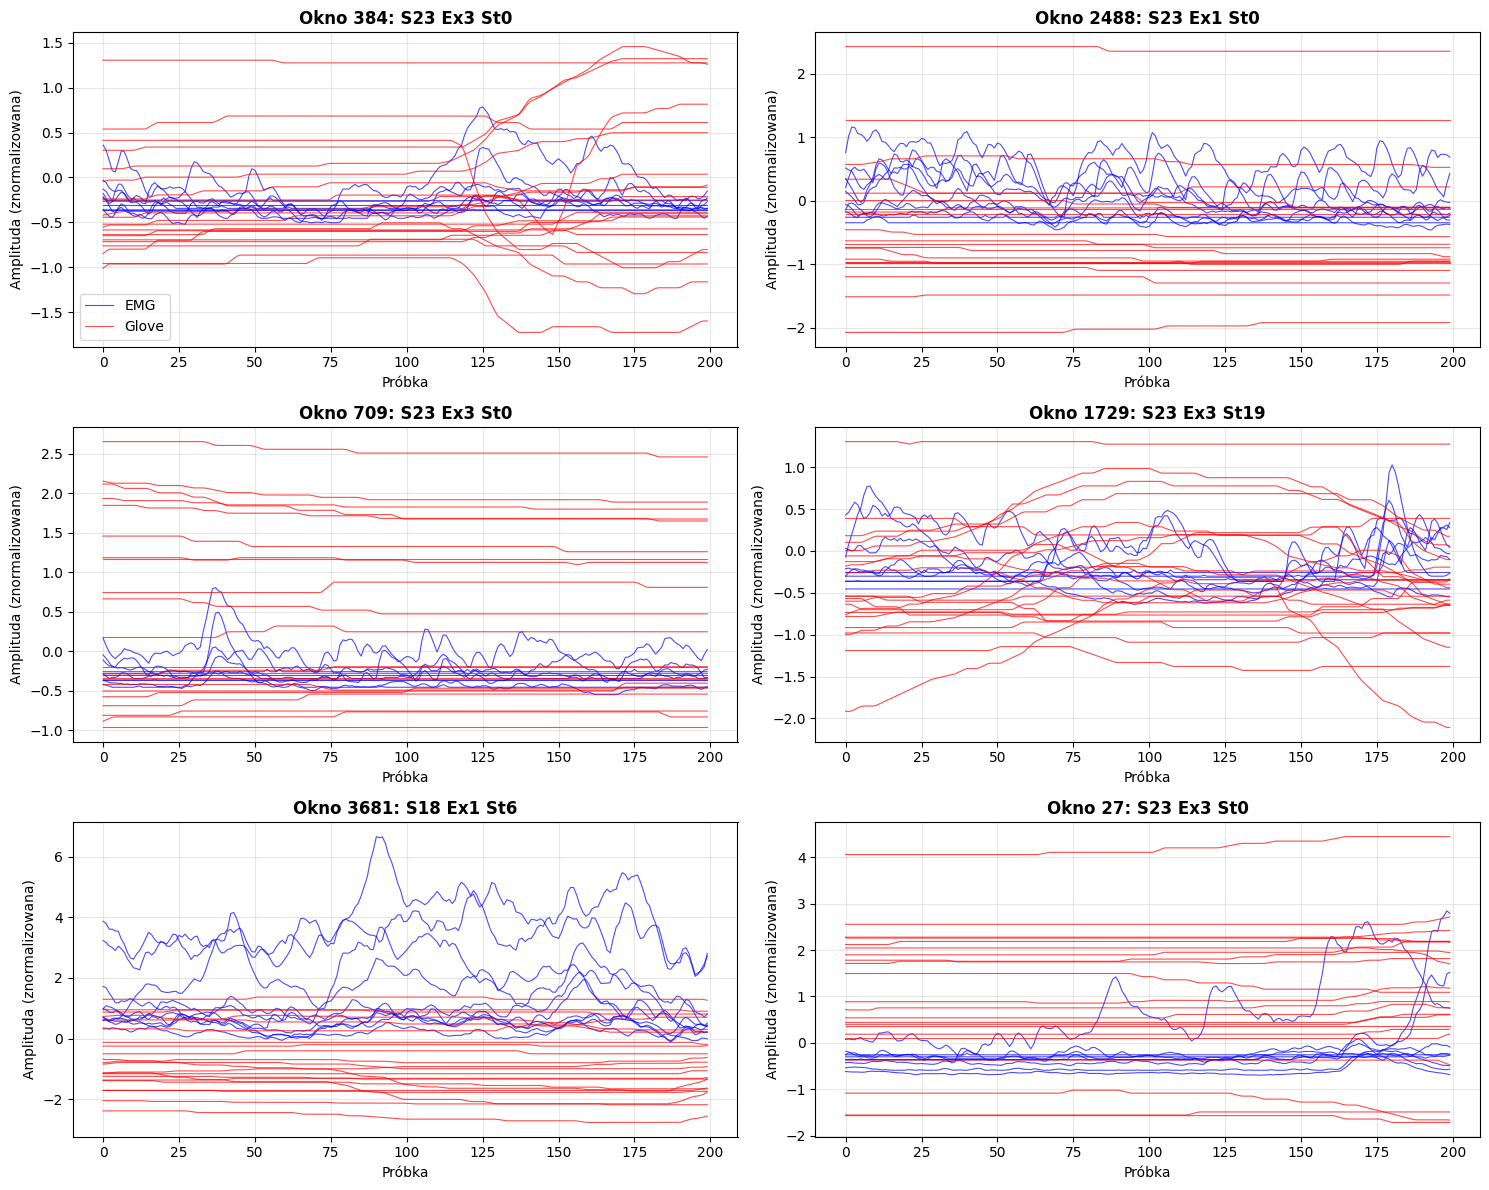


📊 Statystyki wizualizowanych okien:
   Okno 384:
     Subject: 23, Exercise: 3, Stimulus: 0
     Shape: (200, 32)
     Zakres amplitud: [-1.725, 1.456]
     Średnia energia: 0.341914
   Okno 2488:
     Subject: 23, Exercise: 1, Stimulus: 0
     Shape: (200, 32)
     Zakres amplitud: [-2.071, 2.428]
     Średnia energia: 0.763267
   Okno 709:
     Subject: 23, Exercise: 3, Stimulus: 0
     Shape: (200, 32)
     Zakres amplitud: [-0.963, 2.654]
     Średnia energia: 0.933279
   Okno 1729:
     Subject: 23, Exercise: 3, Stimulus: 19
     Shape: (200, 32)
     Zakres amplitud: [-2.108, 1.305]
     Średnia energia: 0.397606
   Okno 3681:
     Subject: 18, Exercise: 1, Stimulus: 6
     Shape: (200, 32)
     Zakres amplitud: [-2.766, 6.660]
     Średnia energia: 2.318561
   Okno 27:
     Subject: 23, Exercise: 3, Stimulus: 0
     Shape: (200, 32)
     Zakres amplitud: [-1.716, 4.444]
     Średnia energia: 2.101005

⚖️ SZCZEGÓŁOWA ANALIZA BALANSU KLAS
🔍 Analiza kombinacji Subject-Exercise:

📉

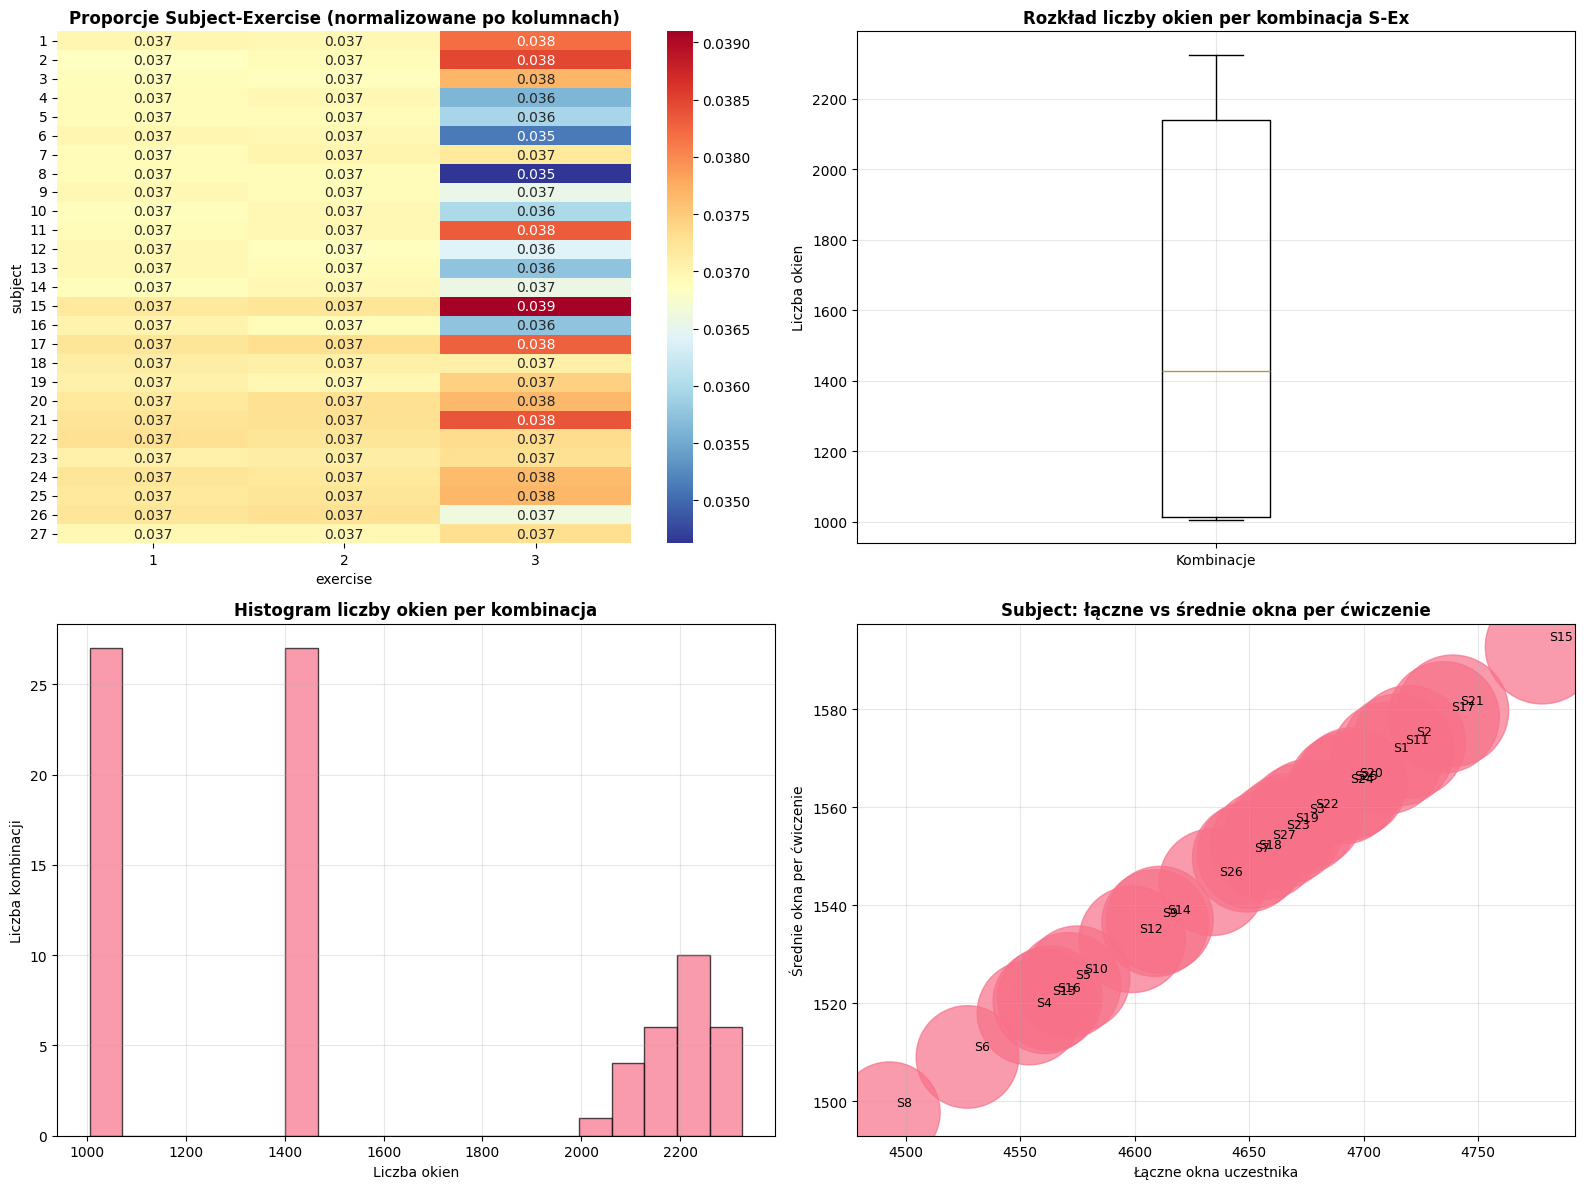


✅ ANALIZA EDA ZAKOŃCZONA

🎉 Analiza EDA zakończona pomyślnie!
   Przeanalizowano 125,409 okien
   Z 27 batch-ów

🔍 Dostępne dodatkowe funkcje:
   analyzer.visualize_emg_windows(num_windows=12)  # Więcej okien
   analyzer.analyze_class_distribution()          # Tylko rozkład klas
   analyzer.check_class_balance_detailed()        # Szczegółowy balans
   analyzer.analyze_window_lengths()              # Tylko długości okien


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class EMGEDAAnalyzer:
    """Klasa do kompleksowej analizy EDA po przetworzeniu sygnałów EMG"""

    def __init__(self, batch_dir="/content/segmented_data"):
        self.batch_dir = batch_dir
        self.batch_info = None
        self.labels_df = None
        self.metadata_df = None
        self.emg_cols = []
        self.glove_cols = []

        # Ładuj podstawowe informacje
        self._load_info()

        # Ustawienia wizualizacji
        plt.style.use('default')
        sns.set_palette("husl")

        print(f"📊 EMG EDA Analyzer zainicjalizowany")
        print(f"   Katalog: {batch_dir}")
        if self.batch_info:
            print(f"   Łączne okna: {self.batch_info.get('total_windows', 0):,}")
            print(f"   Rozmiar okna: {self.batch_info.get('window_size', 'N/A')}")
            print(f"   Overlap: {self.batch_info.get('overlap', 'N/A')}")

    def _load_info(self):
        """Wczytaj podstawowe informacje o danych"""
        try:
            # Wczytaj info o batch-ach
            info_path = f"{self.batch_dir}/batch_info.json"
            if os.path.exists(info_path):
                with open(info_path, 'r') as f:
                    self.batch_info = json.load(f)
                    self.emg_cols = self.batch_info.get('emg_cols', [])
                    self.glove_cols = self.batch_info.get('glove_cols', [])

            # Wczytaj etykiety
            labels_path = f"{self.batch_dir}/all_labels.csv"
            if os.path.exists(labels_path):
                self.labels_df = pd.read_csv(labels_path)
                print(f"📋 Wczytano etykiety: {self.labels_df.shape}")
                print(f"   Dostępne kolumny: {list(self.labels_df.columns)}")

                # Sprawdź czy wymagane kolumny istnieją
                required_cols = ['subject', 'exercise', 'stimulus']
                missing_cols = [col for col in required_cols if col not in self.labels_df.columns]
                if missing_cols:
                    print(f"⚠️ Brakujące kolumny: {missing_cols}")

            # Wczytaj metadane
            meta_path = f"{self.batch_dir}/all_metadata.csv"
            if os.path.exists(meta_path):
                self.metadata_df = pd.read_csv(meta_path)
                print(f"📋 Wczytano metadane: {self.metadata_df.shape}")

        except Exception as e:
            print(f"⚠️ Błąd wczytywania informacji: {e}")

    def _check_required_columns(self, required_cols):
        """Sprawdź czy wymagane kolumny istnieją"""
        if self.labels_df is None:
            return False, ["Brak danych etykiet"]

        missing_cols = [col for col in required_cols if col not in self.labels_df.columns]
        return len(missing_cols) == 0, missing_cols

    def analyze_window_lengths(self):
        """Analiza długości okien"""
        print("\n" + "="*60)
        print("📏 ANALIZA DŁUGOŚCI OKIEN")
        print("="*60)

        if self.batch_info is None:
            print("❌ Brak informacji o batch-ach")
            return

        window_size = self.batch_info.get('window_size', 200)
        total_windows = self.batch_info.get('total_windows', 0)
        overlap = self.batch_info.get('overlap', 0.5)

        print(f"🪟 Parametry okien:")
        print(f"   Rozmiar okna: {window_size} próbek")
        print(f"   Overlap: {overlap*100:.1f}%")
        print(f"   Krok: {int(window_size * (1-overlap))} próbek")
        print(f"   Łączna liczba okien: {total_windows:,}")

        # Analiza długości sygnałów źródłowych
        if self.metadata_df is not None:
            source_files = self.metadata_df['source_file'].unique()
            print(f"\n📁 Pliki źródłowe:")
            print(f"   Liczba plików: {len(source_files)}")

            # Okna per plik
            windows_per_file = self.metadata_df['source_file'].value_counts()

            fig, axes = plt.subplots(2, 2, figsize=(15, 12))

            # Histogram okien per plik
            axes[0, 0].hist(windows_per_file.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0, 0].set_title('Rozkład liczby okien per plik', fontweight='bold', pad=20)
            axes[0, 0].set_xlabel('Liczba okien')
            axes[0, 0].set_ylabel('Liczba plików')
            axes[0, 0].grid(True, alpha=0.3)

            # Box plot okien per plik
            axes[0, 1].boxplot(windows_per_file.values, vert=True)
            axes[0, 1].set_title('Box plot: okna per plik', fontweight='bold', pad=20)
            axes[0, 1].set_ylabel('Liczba okien')
            axes[0, 1].grid(True, alpha=0.3)

            # Top 10 plików z największą liczbą okien
            top_files = windows_per_file.head(10)
            axes[1, 0].barh(range(len(top_files)), top_files.values, color='lightcoral')
            axes[1, 0].set_yticks(range(len(top_files)))
            axes[1, 0].set_yticklabels([f.replace('.parquet', '').replace('.csv', '')[:20] + '...'
                                       if len(f) > 20 else f for f in top_files.index])
            axes[1, 0].set_title('Top 10 plików (liczba okien)', fontweight='bold', pad=20)
            axes[1, 0].set_xlabel('Liczba okien')
            axes[1, 0].grid(True, alpha=0.3)

            # Statystyki okien
            stats_text = f"""Statystyki okien per plik:

Średnia: {windows_per_file.mean():.1f}
Mediana: {windows_per_file.median():.1f}
Min: {windows_per_file.min()}
Max: {windows_per_file.max()}
Std: {windows_per_file.std():.1f}

Łączne okna: {total_windows:,}
Rozmiar okna: {window_size}
Overlap: {overlap*100:.1f}%"""

            axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                           fontsize=11, verticalalignment='top', fontfamily='monospace',
                           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
            axes[1, 1].set_xlim(0, 1)
            axes[1, 1].set_ylim(0, 1)
            axes[1, 1].axis('off')
            axes[1, 1].set_title('Statystyki', fontweight='bold', pad=20)

            plt.tight_layout()
            plt.show()

            print(f"\n📊 Statystyki okien per plik:")
            print(f"   Średnia: {windows_per_file.mean():.1f} okien/plik")
            print(f"   Mediana: {windows_per_file.median():.1f} okien/plik")
            print(f"   Min-Max: {windows_per_file.min()} - {windows_per_file.max()} okien")

    def analyze_class_distribution(self):
        """Analiza rozkładu klas po oknach"""
        print("\n" + "="*60)
        print("🎯 ANALIZA ROZKŁADU KLAS")
        print("="*60)

        if self.labels_df is None:
            print("❌ Brak danych o etykietach")
            return

        # Sprawdź dostępne kolumny
        available_cols = list(self.labels_df.columns)
        print(f"📋 Dostępne kolumny: {available_cols}")

        # Mapowanie kolumn - sprawdź różne nazwy
        col_mapping = {}
        possible_names = {
            'subject': ['subject', 'Subject', 'participant', 'user_id', 'subject_id'],
            'exercise': ['exercise', 'Exercise', 'task', 'movement', 'gesture', 'class'],
            'stimulus': ['stimulus', 'Stimulus', 'repetition', 'trial', 'rep']
        }

        for standard_name, possible in possible_names.items():
            for possible_name in possible:
                if possible_name in available_cols:
                    col_mapping[standard_name] = possible_name
                    break

        print(f"🔍 Mapowanie kolumn: {col_mapping}")

        if not col_mapping:
            print("❌ Nie znaleziono standardowych kolumn klasyfikacyjnych")
            print("   Spróbuję analizować wszystkie numeryczne kolumny...")

            # Analiza wszystkich numerycznych kolumn
            numeric_cols = self.labels_df.select_dtypes(include=[np.number]).columns.tolist()

            if not numeric_cols:
                print("❌ Brak kolumn numerycznych do analizy")
                return

            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes = axes.flatten()

            for i, col in enumerate(numeric_cols[:4]):  # Max 4 kolumny
                if i < len(axes):
                    value_counts = self.labels_df[col].value_counts().sort_index()
                    axes[i].bar(value_counts.index, value_counts.values, alpha=0.8)
                    axes[i].set_title(f'Rozkład: {col}', fontweight='bold')
                    axes[i].set_xlabel('Wartość')
                    axes[i].set_ylabel('Liczba okien')
                    axes[i].grid(True, alpha=0.3)

            # Usuń nieużywane subploty
            for i in range(len(numeric_cols), len(axes)):
                fig.delaxes(axes[i])

            plt.tight_layout()
            plt.show()
            return

        # Standardowa analiza z mapowanymi kolumnami
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        total_windows = len(self.labels_df)

        # 1. Rozkład uczestników/subjects
        if 'subject' in col_mapping:
            subject_col = col_mapping['subject']
            subject_counts = self.labels_df[subject_col].value_counts().sort_index()
            axes[0, 0].bar(subject_counts.index, subject_counts.values, alpha=0.8, color='lightblue')
            axes[0, 0].set_title(f'Rozkład: {subject_col}', fontweight='bold', pad=20)
            axes[0, 0].set_xlabel(f'{subject_col} ID')
            axes[0, 0].set_ylabel('Liczba okien')
            axes[0, 0].grid(True, alpha=0.3)

            # Dodaj wartości na słupkach
            for i, v in enumerate(subject_counts.values):
                axes[0, 0].text(subject_counts.index[i], v + max(subject_counts.values)*0.01,
                               f'{v:,}', ha='center', va='bottom', fontsize=9)
        else:
            axes[0, 0].text(0.5, 0.5, 'Brak kolumny\nsubject/participant',
                           ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Subject (brak danych)')

        # 2. Rozkład ćwiczeń/exercises
        if 'exercise' in col_mapping:
            exercise_col = col_mapping['exercise']
            exercise_counts = self.labels_df[exercise_col].value_counts().sort_index()
            axes[0, 1].bar(exercise_counts.index, exercise_counts.values, alpha=0.8, color='lightgreen')
            axes[0, 1].set_title(f'Rozkład: {exercise_col}', fontweight='bold', pad=20)
            axes[0, 1].set_xlabel(f'{exercise_col} ID')
            axes[0, 1].set_ylabel('Liczba okien')
            axes[0, 1].grid(True, alpha=0.3)

            for i, v in enumerate(exercise_counts.values):
                axes[0, 1].text(exercise_counts.index[i], v + max(exercise_counts.values)*0.01,
                               f'{v:,}', ha='center', va='bottom', fontsize=9)
        else:
            axes[0, 1].text(0.5, 0.5, 'Brak kolumny\nexercise/task',
                           ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Exercise (brak danych)')

        # 3. Rozkład stimuli
        if 'stimulus' in col_mapping:
            stimulus_col = col_mapping['stimulus']
            stimulus_counts = self.labels_df[stimulus_col].value_counts().sort_index()
            axes[0, 2].bar(stimulus_counts.index, stimulus_counts.values, alpha=0.8, color='lightcoral')
            axes[0, 2].set_title(f'Rozkład: {stimulus_col}', fontweight='bold', pad=20)
            axes[0, 2].set_xlabel(f'{stimulus_col} ID')
            axes[0, 2].set_ylabel('Liczba okien')
            axes[0, 2].grid(True, alpha=0.3)

            for i, v in enumerate(stimulus_counts.values):
                axes[0, 2].text(stimulus_counts.index[i], v + max(stimulus_counts.values)*0.01,
                               f'{v:,}', ha='center', va='bottom', fontsize=9)
        else:
            axes[0, 2].text(0.5, 0.5, 'Brak kolumny\nstimulus/repetition',
                           ha='center', va='center', transform=axes[0, 2].transAxes)
            axes[0, 2].set_title('Stimulus (brak danych)')

        # 4. Pie chart - główna klasa
        main_class_col = None
        if 'exercise' in col_mapping:
            main_class_col = col_mapping['exercise']
            main_counts = exercise_counts
        elif 'subject' in col_mapping:
            main_class_col = col_mapping['subject']
            main_counts = subject_counts

        if main_class_col:
            axes[1, 0].pie(main_counts.values, labels=[f'{main_class_col[0].upper()}{i}' for i in main_counts.index],
                          autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(main_counts)))
            axes[1, 0].set_title(f'Proporcje: {main_class_col}', fontweight='bold', pad=20)
        else:
            axes[1, 0].text(0.5, 0.5, 'Brak danych\ndo pie chart',
                           ha='center', va='center', transform=axes[1, 0].transAxes)

        # 5. Heatmapa (jeśli mamy co najmniej 2 kolumny)
        if len(col_mapping) >= 2:
            cols_for_heatmap = list(col_mapping.values())[:2]
            pivot_table = pd.crosstab(self.labels_df[cols_for_heatmap[0]],
                                    self.labels_df[cols_for_heatmap[1]])
            sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1])
            axes[1, 1].set_title(f'{cols_for_heatmap[0]} vs {cols_for_heatmap[1]}', fontweight='bold', pad=20)
        else:
            axes[1, 1].text(0.5, 0.5, 'Potrzeba ≥2 kolumn\ndla heatmapy',
                           ha='center', va='center', transform=axes[1, 1].transAxes)

        # 6. Statystyki
        stats_text = f"STATYSTYKI DANYCH\n\n"
        stats_text += f"Łączne okna: {total_windows:,}\n\n"

        for standard_name, actual_col in col_mapping.items():
            counts = self.labels_df[actual_col].value_counts()
            balance = self._calculate_balance_metrics(counts)

            stats_text += f"{standard_name.upper()} ({actual_col}):\n"
            stats_text += f"  Klasy: {len(counts)}\n"
            stats_text += f"  Min: {counts.min():,} ({counts.min()/total_windows*100:.1f}%)\n"
            stats_text += f"  Max: {counts.max():,} ({counts.max()/total_windows*100:.1f}%)\n"
            stats_text += f"  Gini: {balance['gini']:.3f}\n"
            stats_text += f"  CV: {balance['cv']:.3f}\n\n"

        axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes,
                       fontsize=10, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        axes[1, 2].set_xlim(0, 1)
        axes[1, 2].set_ylim(0, 1)
        axes[1, 2].axis('off')

        plt.tight_layout()
        plt.show()

        # Wydrukuj szczegółowe statystyki
        print(f"\n📊 SZCZEGÓŁOWE STATYSTYKI KLAS:")
        for standard_name, actual_col in col_mapping.items():
            counts = self.labels_df[actual_col].value_counts().sort_index()
            print(f"\n{standard_name.upper()} ({actual_col}):")
            for idx, count in counts.items():
                print(f"   {actual_col} {idx}: {count:,} okien ({count/total_windows*100:.1f}%)")

        # Ostrzeżenia o balansie
        if col_mapping:
            balance_metrics = {}
            for standard_name, actual_col in col_mapping.items():
                counts = self.labels_df[actual_col].value_counts()
                balance_metrics[standard_name] = self._calculate_balance_metrics(counts)

            self._print_balance_warnings(balance_metrics)

    def _calculate_balance_metrics(self, counts):
        """Oblicz metryki balansu klas"""
        proportions = counts / counts.sum()

        # Współczynnik Giniego
        sorted_props = np.sort(proportions)
        n = len(sorted_props)
        cumsum = np.cumsum(sorted_props)
        gini = (n + 1 - 2 * np.sum(cumsum)) / n

        # Współczynnik zmienności
        cv = np.std(counts) / np.mean(counts)

        return {
            'gini': gini,
            'cv': cv,
            'min_prop': proportions.min(),
            'max_prop': proportions.max(),
            'std_prop': proportions.std()
        }

    def _print_balance_warnings(self, balance_metrics):
        """Wydrukuj ostrzeżenia o niezbalansowaniu (elastyczna wersja)"""
        print(f"\n⚠️ OSTRZEŻENIA O BALANSIE:")

        for standard_name, metrics in balance_metrics.items():
            gini = metrics['gini']
            actual_col = list(self.labels_df.columns).index(standard_name) # Get actual column name from mapping if needed

            if gini > 0.3:
                print(f"   🔴 {standard_name.capitalize()} ({actual_col}) są mocno niezbalansowane (Gini: {gini:.3f})")
            elif gini > 0.1:
                print(f"   🟡 {standard_name.capitalize()} ({actual_col}) są umiarkowanie niezbalansowane (Gini: {gini:.3f})")
            else:
                print(f"   🟢 {standard_name.capitalize()} ({actual_col}) są dobrze zbalansowane (Gini: {gini:.3f})")


    def visualize_emg_windows(self, num_windows=6, window_indices=None, batch_index=0):
        """Wizualizacja przykładowych okien EMG"""
        print("\n" + "="*60)
        print("📈 WIZUALIZACJA OKIEN EMG")
        print("="*60)

        # Wczytaj dane z jednego batch-a
        try:
            batch_files = self.batch_info.get('batch_files', [])
            if not batch_files or batch_index >= len(batch_files):
                print("❌ Nie można wczytać danych batch-a")
                return

            batch_path = f"{self.batch_dir}/{batch_files[batch_index]}"
            data = np.load(batch_path, allow_pickle=True)
            X = data['X']  # Shape: (n_windows, window_size, n_channels)
            y = pd.DataFrame(data['y'])
            y = pd.DataFrame(data['y'])

              # y = pd.DataFrame(data['y'])
            y_raw = data['y']  # to jest np. array of dicts
            if isinstance(y_raw, np.ndarray) and isinstance(y_raw[0], dict):
                y = pd.DataFrame(list(y_raw))
            else:
                y = pd.DataFrame(y_raw)
            print("y columns po naprawie:", y.columns)
            print(y.head())



            print(f"📊 Wczytano batch {batch_index}: {X.shape}")

        except Exception as e:
            print(f"❌ Błąd wczytywania danych: {e}")
            return

        # Wybierz okna do wizualizacji
        if window_indices is None:
            # Wybierz losowe okna z różnych klas
            unique_exercises = y['exercise'].unique()
            window_indices = []

            for ex in unique_exercises[:num_windows]:
                ex_windows = y[y['exercise'] == ex].index.tolist()
                if ex_windows:
                    window_indices.append(np.random.choice(ex_windows))

            # Dopełnij losowymi jeśli potrzeba
            while len(window_indices) < num_windows and len(window_indices) < len(X):
                remaining_indices = [i for i in range(len(X)) if i not in window_indices]
                if remaining_indices:
                    window_indices.append(np.random.choice(remaining_indices))

        window_indices = window_indices[:num_windows]

        # Stwórz subplot grid
        cols = 2
        rows = (len(window_indices) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)

        # Kolory dla różnych typów kanałów
        emg_color = 'blue'
        glove_color = 'red'

        for idx, window_idx in enumerate(window_indices):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col]

            # Pobierz dane okna
            window_data = X[window_idx]  # Shape: (window_size, n_channels)
            window_label = y.iloc[window_idx]

            # Wizualizuj kanały
            time_axis = np.arange(window_data.shape[0])

            # EMG channels
            emg_channels = len(self.emg_cols)
            if emg_channels > 0:
                for ch in range(min(emg_channels, window_data.shape[1])):
                    ax.plot(time_axis, window_data[:, ch],
                           color=emg_color, alpha=0.7, linewidth=0.8,
                           label='EMG' if ch == 0 else "")

            # Glove channels (jeśli istnieją)
            glove_channels = len(self.glove_cols)
            if glove_channels > 0 and window_data.shape[1] > emg_channels:
                for ch in range(emg_channels, min(emg_channels + glove_channels, window_data.shape[1])):
                    ax.plot(time_axis, window_data[:, ch],
                           color=glove_color, alpha=0.7, linewidth=0.8,
                           label='Glove' if ch == emg_channels else "")

            # Formatowanie
            ax.set_title(f'Okno {window_idx}: S{window_label["subject"]} Ex{window_label["exercise"]} St{window_label["stimulus"]}',
                        fontweight='bold')
            ax.set_xlabel('Próbka')
            ax.set_ylabel('Amplituda (znormalizowana)')
            ax.grid(True, alpha=0.3)

            # Legenda tylko dla pierwszego okna
            if idx == 0:
                ax.legend()

        # Usuń puste subploty
        for idx in range(len(window_indices), rows * cols):
            row = idx // cols
            col = idx % cols
            fig.delaxes(axes[row, col])

        plt.tight_layout()
        plt.show()

        # Statystyki okien
        print(f"\n📊 Statystyki wizualizowanych okien:")
        for i, window_idx in enumerate(window_indices):
            window_data = X[window_idx]
            window_label = y.iloc[window_idx]

            print(f"   Okno {window_idx}:")
            print(f"     Subject: {window_label['subject']}, Exercise: {window_label['exercise']}, Stimulus: {window_label['stimulus']}")
            print(f"     Shape: {window_data.shape}")
            print(f"     Zakres amplitud: [{window_data.min():.3f}, {window_data.max():.3f}]")
            print(f"     Średnia energia: {np.mean(window_data**2):.6f}")

    def check_class_balance_detailed(self):
        """Szczegółowa analiza balansu klas z rekomendacjami"""
        print("\n" + "="*60)
        print("⚖️ SZCZEGÓŁOWA ANALIZA BALANSU KLAS")
        print("="*60)

        if self.labels_df is None:
            print("❌ Brak danych o etykietach")
            return

        total_windows = len(self.labels_df)

        # Analiza kombinacji klas
        print(f"🔍 Analiza kombinacji Subject-Exercise:")

        combination_counts = self.labels_df.groupby(['subject', 'exercise']).size().reset_index(name='count')
        combination_counts['percentage'] = combination_counts['count'] / total_windows * 100

        # Najrzadsze kombinacje
        rarest = combination_counts.nsmallest(5, 'count')
        print(f"\n📉 5 najrzadszych kombinacji Subject-Exercise:")
        for _, row in rarest.iterrows():
            print(f"   S{row['subject']}-Ex{row['exercise']}: {row['count']} okien ({row['percentage']:.2f}%)")

        # Najczęstsze kombinacje
        most_common = combination_counts.nlargest(5, 'count')
        print(f"\n📈 5 najczęstszych kombinacji Subject-Exercise:")
        for _, row in most_common.iterrows():
            print(f"   S{row['subject']}-Ex{row['exercise']}: {row['count']} okien ({row['percentage']:.2f}%)")

        # Rekomendacje balansowania
        print(f"\n💡 REKOMENDACJE BALANSOWANIA:")

        exercise_counts = self.labels_df['exercise'].value_counts()
        subject_counts = self.labels_df['subject'].value_counts()

        # Sprawdź czy jakieś klasy są znacznie niedoreprezentowane
        min_exercise_count = exercise_counts.min()
        max_exercise_count = exercise_counts.max()
        exercise_ratio = max_exercise_count / min_exercise_count

        if exercise_ratio > 10:
            print(f"   🔴 KRYTYCZNE: Różnica między klasami ćwiczeń wynosi {exercise_ratio:.1f}x")
            print(f"      Rozważ użycie technik balansowania (SMOTE, undersampling, class weights)")
        elif exercise_ratio > 3:
            print(f"   🟡 OSTRZEŻENIE: Różnica między klasami ćwiczeń wynosi {exercise_ratio:.1f}x")
            print(f"      Zalecane użycie class weights w modelu")
        else:
            print(f"   🟢 OK: Klasy ćwiczeń są względnie zbalansowane (ratio: {exercise_ratio:.1f}x)")

        # Sprawdź subjects
        min_subject_count = subject_counts.min()
        max_subject_count = subject_counts.max()
        subject_ratio = max_subject_count / min_subject_count

        if subject_ratio > 5:
            print(f"   🔴 KRYTYCZNE: Różnica między uczestnikami wynosi {subject_ratio:.1f}x")
            print(f"      Rozważ stratified sampling lub leave-one-subject-out validation")
        elif subject_ratio > 2:
            print(f"   🟡 OSTRZEŻENIE: Różnica między uczestnikami wynosi {subject_ratio:.1f}x")
            print(f"      Użyj stratified split ze względu na subjects")
        else:
            print(f"   🟢 OK: Dane uczestników są względnie zbalansowane (ratio: {subject_ratio:.1f}x)")

        # Wizualizacja szczegółowa
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Szczegółowa heatmapa
        pivot_detailed = pd.crosstab(self.labels_df['subject'], self.labels_df['exercise'], normalize='columns')
        sns.heatmap(pivot_detailed, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=axes[0, 0])
        axes[0, 0].set_title('Proporcje Subject-Exercise (normalizowane po kolumnach)', fontweight='bold')

        # 2. Box plot rozkładu kombinacji
        axes[0, 1].boxplot([combination_counts['count'].values], labels=['Kombinacje'])
        axes[0, 1].set_title('Rozkład liczby okien per kombinacja S-Ex', fontweight='bold')
        axes[0, 1].set_ylabel('Liczba okien')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Histogram kombinacji
        axes[1, 0].hist(combination_counts['count'], bins=20, alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Histogram liczby okien per kombinacja', fontweight='bold')
        axes[1, 0].set_xlabel('Liczba okien')
        axes[1, 0].set_ylabel('Liczba kombinacji')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Scatter plot Subject vs Exercise counts
        subj_ex_summary = combination_counts.groupby('subject')['count'].agg(['sum', 'mean', 'std']).reset_index()
        axes[1, 1].scatter(subj_ex_summary['sum'], subj_ex_summary['mean'],
                          s=subj_ex_summary['std']*10, alpha=0.7)
        axes[1, 1].set_xlabel('Łączne okna uczestnika')
        axes[1, 1].set_ylabel('Średnie okna per ćwiczenie')
        axes[1, 1].set_title('Subject: łączne vs średnie okna per ćwiczenie', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

        # Dodaj etykiety do punktów
        for _, row in subj_ex_summary.iterrows():
            axes[1, 1].annotate(f'S{int(row["subject"])}',
                               (row['sum'], row['mean']),
                               xytext=(5, 5), textcoords='offset points', fontsize=9)

        plt.tight_layout()
        plt.show()

    def run_complete_eda(self):
        """Uruchom kompletną analizę EDA"""
        print("🚀 ROZPOCZYNAM KOMPLETNĄ ANALIZĘ EDA")
        print("="*60)

        # 1. Analiza długości okien
        self.analyze_window_lengths()

        # 2. Analiza rozkładu klas
        self.analyze_class_distribution()

        # 3. Wizualizacja przykładowych okien EMG
        self.visualize_emg_windows(num_windows=6)

        # 4. Szczegółowa analiza balansu
        self.check_class_balance_detailed()

        print("\n" + "="*60)
        print("✅ ANALIZA EDA ZAKOŃCZONA")
        print("="*60)

        return True

def run_emg_eda_analysis(batch_dir="/content/segmented_data"):
    """Funkcja uruchamiająca kompletną analizę EDA"""

    print("📊 EMG EDA ANALYSIS TOOL")
    print("="*50)

    # Sprawdź czy katalog istnieje
    if not os.path.exists(batch_dir):
        print(f"❌ Katalog {batch_dir} nie istnieje!")
        return None

    # Inicjalizuj analyzer
    analyzer = EMGEDAAnalyzer(batch_dir)



    # Sprawdź czy dane są dostępne
    if analyzer.batch_info is None:
        print("❌ Brak informacji o batch-ach - sprawdź czy preprocessing został zakończony")
        return None

    if analyzer.labels_df is None:
        print("❌ Brak pliku z etykietami - sprawdź czy preprocessing został zakończony")
        return None

    # Uruchom kompletną analizę
    success = analyzer.run_complete_eda()

    if success:
        print(f"\n🎉 Analiza EDA zakończona pomyślnie!")
        print(f"   Przeanalizowano {len(analyzer.labels_df):,} okien")
        print(f"   Z {analyzer.batch_info['num_batches']} batch-ów")

        return analyzer

    return None

# Przykład użycia:
if __name__ == "__main__":

    # Uruchom analizę EDA
    analyzer = run_emg_eda_analysis("/content/segmented_data")



    if analyzer:
        print("\n🔍 Dostępne dodatkowe funkcje:")
        print("   analyzer.visualize_emg_windows(num_windows=12)  # Więcej okien")
        print("   analyzer.analyze_class_distribution()          # Tylko rozkład klas")
        print("   analyzer.check_class_balance_detailed()        # Szczegółowy balans")
        print("   analyzer.analyze_window_lengths()              # Tylko długości okien")